# Balance of Evidence -  simulations Balance of evidence -  ΣValue  (Value experiment)
# Figure 6B
--------------------------------------

In [42]:
import glam
import pandas as pd
import numpy as np
import os.path
from statsmodels.stats.outliers_influence import summary_table
import matplotlib.patches as mpatches


In [43]:
import matplotlib.pyplot as plt

from scipy.stats import invgauss
import seaborn as sns
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
from scipy import stats
from scipy.stats.stats import pearsonr # Pearson's correlation
import statsmodels.api as sm

#import warnings
#warnings.filterwarnings('ignore')

In [44]:
np.random.seed(23) # from random.org

In [45]:
# For rpy2

import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [46]:
# For MacMini proper running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load required functions

In [47]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

In [197]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [50]:
def balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats):
    
    mean_rts_trials = np.zeros((value_tests.shape[0])) * np.nan
    choice_trials = np.zeros((value_tests.shape[0])) * np.nan
    DEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    AbsDEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    Ev_drifts_0_trials  = []
    Ev_drifts_1_trials = []

    n_trials, n_items = value_tests.shape

    running_idx_value = 0
    #we iterate for all the combinations of trials + gaze
    for trial in range(n_trials):
        
            # intialize the drifts
            evidence_drifts_0 = []
            evidence_drifts_1 = []

            #define value and gaze values for this particular trial
            value_trial =value_tests[trial]
            gaze_trial =gaze_tests[trial]
            
            Sim_value = value_trial
            Sim_gaze = gaze_trial
            
            Delta_E = np.zeros(n_repeats) * np.nan            
            AbsDelta_E = np.zeros(n_repeats) * np.nan
            rts = np.zeros(n_repeats) * np.nan
            choices = np.zeros(n_repeats) * np.nan
            trial_idx = np.zeros(n_repeats) * np.nan
            repeat_idx = np.zeros(n_repeats) * np.nan
            running_idx = 0
        
            for repeat in range(n_repeats):
                    

                    
                    Evi_0, Evi_1, choice, rt = glam.driftSim.simulate_trial_drift(parameters, value_trial, gaze_trial,
                                                boundary=boundary,
                                                error_weight=error_weight,
                                                error_range=error_range)
                    
                    Delta_E[running_idx] = Evi_1[-1] - Evi_0[-1]
                    AbsDelta_E[running_idx] = abs(Evi_0[-1] - Evi_1[-1])                        
                    rts[running_idx] = rt
                    choices[running_idx] = choice
                    trial_idx[running_idx] = trial
                    repeat_idx[running_idx] = repeat
                    # Add a new sequence of drift for this particular trial
                    evidence_drifts_0.append(Evi_0)
                    evidence_drifts_1.append(Evi_1)
                    
                    running_idx += 1
                    
               
            # Add the mean value for this parameters interation               
            mean_rts_trials [running_idx_value] = rts.mean()
            choice_trials [running_idx_value]= choices.mean() 
            DEv_trials [running_idx_value] = Delta_E.mean()
            AbsDEv_trials [running_idx_value]= AbsDelta_E.mean()
            Ev_drifts_0_trials.append(evidence_drifts_0)
            Ev_drifts_1_trials.append(evidence_drifts_1)
 
            running_idx_value += 1 

    return AbsDEv_trials,mean_rts_trials,Ev_drifts_0_trials,Ev_drifts_1_trials,choice_trials

In [51]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

    
        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [52]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

In [53]:
def add_difficulty(df):
    """
    Compute trial difficulties and add to DataFrame.

    Maximum value -  other values.
    In the binary case, this reduces to abs(v0 - v1).

    Parameters
    ----------
    df :      <pandas DataFrame>
              Trial wise DataFrame containing columns for item_value_i
    """

    values = df[['LVal','RVal']].values
    values_sorted = np.sort(values, axis=1)
    difficulty = values_sorted[:, -1] - np.mean(values_sorted[:, :-1], axis=1)

    levels =  (np.max(difficulty) - np.min(difficulty))/10

    lev_label = np.arange(np.min(difficulty), np.max(difficulty) + levels,levels) 
    
    difficulty2= []
    for i in range(len(difficulty)):
         difficulty2.append( lev_label[ int(difficulty[i]//levels)] )
     
    difficulty = difficulty2
    
    df['difficulty'] = np.around(difficulty, decimals = 0)
    df['difficulty'] = difficulty
    
    return df.copy()

In [54]:
def plot_DEv_Conf(data, ax=None, xlims=(0, 10), xlabel_skip=2,color1 = '#4F6A9A',label1 = 'Like',label2 = 'GLAM Simulations'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 15))
        # Set seaborn style for the plot
        sns.set(style='white')

    df = data.copy()

    # Compute relevant variables
    df = add_difficulty(df)
    
    
    # select data to use
    
    data_labels = ['zConf_human','zAbsDEv']
    
    for i in range(len(data_labels)):
        # Compute summary statistics
        subject_means = df.groupby(['Part', 'difficulty'])[data_labels[i]].mean()
        means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
        sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]
    
        x = np.arange(len(means))
        
        # Add labels for scatter plot of mean rt per participant
        scatter_data = subject_means.reset_index()
        x_scatter = []
        group_labels = np.sort(scatter_data.difficulty.unique())
        for ii in range(len(scatter_data.difficulty.values)):
            a = scatter_data.difficulty.values[ii]
            position_item =  x[np.where(group_labels==a)[0][0]]
            x_scatter.append(position_item) 
        ## ********    
        
        predicted = False if i == 0 else True
        
        # Colors for predicted
        c_pred = [color1,'#606060','#607681' ]
        
        if not predicted:  # plot underlying data
            ax.plot(x, means, 'o', markerfacecolor=color1, markersize = 10, fillstyle = 'full',
                    color=color1, linewidth=1)
            ax.vlines(x, means - sems, means + sems,
                      linewidth=1, color= color1)
            jittr = np.random.uniform(low=-max(x)/20,high=max(x)/20,size=len(scatter_data))/2
            ax.plot(x_scatter+jittr, scatter_data[data_labels[i]].values, marker='o', ms=5, color=color1,alpha=0.3,linestyle="None")
    
        else:  # plot predictions
            ax.plot(x, means, '-o', markerfacecolor=c_pred[i],color=c_pred[i], linewidth=2.5, markersize = 10)

    #ax.set_ylim(2000, 3500)
    font_size_this = 40
    ax.set_xlabel('|ΔValue|',fontsize=font_size_this)
    ax.set_ylabel( r'zΔe / zConfidence',fontsize=font_size_this)
    ax.set_xticks(x[::xlabel_skip])
    ax.tick_params(axis = 'y',labelsize=font_size_this)
    ax.tick_params(axis = 'x',labelsize=font_size_this)

    ax.set_xticklabels(np.around(means.index.values[::xlabel_skip],decimals = 1))
    
    patch1 = mpatches.Patch(facecolor=color1,hatch=r'', label = label1)
    patch2 = mpatches.Patch(facecolor='#606060',hatch=r'', label = label2)

    leg = plt.legend(handles=[patch1,patch2],fontsize=25,loc = 'lower right')
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
    
    sns.despine()



In [55]:
def add_difficulty_TotVal(df,TotVal_label):
    """
    Compute trial difficulties and add to DataFrame.

    Maximum value -  other values.
    In the binary case, this reduces to abs(v0 - v1).

    Parameters
    ----------
    df :      <pandas DataFrame>
              Trial wise DataFrame containing columns for item_value_i
    """

    difficulty = df[[TotVal_label]].values

    levels =  (np.max(difficulty) - np.min(difficulty))/10

    lev_label = np.arange(np.min(difficulty), np.max(difficulty) + levels,levels) 
    
    difficulty2= []
    for i in range(len(difficulty)):
         difficulty2.append( lev_label[ int(difficulty[i]//levels)] )
     
    difficulty = difficulty2
    
    df['difficulty'] = np.around(difficulty, decimals = 0)
    df['difficulty'] = difficulty
    
    return df.copy()

In [56]:
def plot_DEv_Conf_TotVal(data, TotVal_label, ax=None, xlims=(0, 10), xlabel_skip=2,color1 = '#4F6A9A',label1 = 'Like',label2 = 'GLAM Simulations'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 15))
        # Set seaborn style for the plot
        sns.set(style='white')

    df = data.copy()

    # Compute relevant variables
    df = add_difficulty_TotVal(df,TotVal_label)
    print ('Done with TotVal')
    
    # select data to use
    
    data_labels = ['zConf_human','zAbsDEv']
    
    for i in range(len(data_labels)):
        # Compute summary statistics
        subject_means = df.groupby(['Part','difficulty'])[data_labels[i]].mean()
        means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
        sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]
    
        x = np.arange(len(means))
        
        # Add labels for scatter plot of mean rt per participant
        scatter_data = subject_means.reset_index()
        x_scatter = []
        group_labels = np.sort(scatter_data.difficulty.unique())
        for ii in range(len(scatter_data.difficulty.values)):
            a = scatter_data.difficulty.values[ii]
            position_item =  x[np.where(group_labels==a)[0][0]]
            x_scatter.append(position_item) 
        ## ********    
        
        predicted = False if i == 0 else True
        
        # Colors for predicted
        c_pred = [color1,'#606060','#607681' ]
        
        if not predicted:  # plot underlying data
            ax.plot(x, means, 'o', markerfacecolor=color1, markersize = 10, fillstyle = 'full',
                    color=color1, linewidth=1)
            ax.vlines(x, means - sems, means + sems,
                      linewidth=1, color= color1)
            jittr = np.random.uniform(low=-max(x)/20,high=max(x)/20,size=len(scatter_data))/2
            ax.plot(x_scatter+jittr, scatter_data[data_labels[i]].values, marker='o', ms=5, color=color1,alpha=0.3,linestyle="None")
    
        else:  # plot predictions
            ax.plot(x, means, '-o', markerfacecolor=c_pred[i],color=c_pred[i], linewidth=2.5, markersize = 10)
    font_size_this = 40
    #ax.set_ylim(2000, 3500)
    ax.set_xlabel('|ΣValue|',fontsize=font_size_this)
    ax.set_ylabel( r'zΔe / zConfidence',fontsize=font_size_this)
    ax.set_xticks(x[::xlabel_skip])
    ax.tick_params(axis = 'y',labelsize=font_size_this)
    ax.tick_params(axis = 'x',labelsize=font_size_this)
    ax.set_xticklabels(np.around(means.index.values[::xlabel_skip],decimals = 1))
    
    patch1 = mpatches.Patch(facecolor=color1,hatch=r'', label = label1)
    patch2 = mpatches.Patch(facecolor='#606060',hatch=r'', label = label2)

    leg = plt.legend(handles=[patch1,patch2],fontsize=25,loc = 'lower right')
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
    
    sns.despine()


## load rpy2 toolboxes

In [49]:
%%R
library(lme4)
#library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)  # required for coefplot
library(multcomp)
library(pbkrtest)

## Define some parameters for the simulations


In [57]:
# Parameters for the simulations
boundary=1 # evidence accumulation thresholds
error_weight=0.05 #error weight for the simulations

----------------------------------

# Load data and GLAM structure (Like & Dislike)
Used no bins data for simulation. Value for dislike frames is already inverted

In [58]:
data = pd.read_csv(str('data/value/GlamDataFF2018_Like_NoBin_31.csv'))
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

data2 = pd.read_csv(str('data/value/GlamDataFF2018_Dislike_NoBin_Inv_31.csv'))
# Subset only necessary columns
data2 = data2[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

In [59]:
# Load data for FF2018 study 

# Like condition 

data_all0 = pd.read_csv('data/value/DataFoodFramingNotebook_31.csv')
data_all0 = data_all0.drop(['Unnamed: 0'], axis=1)
data_all = data_all0.loc[data_all0['BlockCond'] == 1] # 1 = Like, 2 = Dislike

data_all=data_all.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

# Dislike condition

data_all2 = data_all0.loc[data_all0['BlockCond'] == 2] # 1 = Like, 2 = Dislike

data_all2=data_all2.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

---------------------------------------------------------
# Like frame


## Load parameter estimates for participants


Use the parameter estimates from GLAM fit for Like, Binned data

In [60]:
sufix = 'individual_Like_NoBin_Gamma-11_NUTS_31'
glam_full = glam.GLAM(data)
glam_full.estimates = np.load(str('results/estimates/glam_FF2019_full_'+sufix+'.npy'))

# generate dataframe with new params
params_part_like = pd.DataFrame()
for i in range(len(glam_full.estimates)):    
    params_part_like1 = pd.DataFrame.from_dict(glam_full.estimates.item(i))
    params_part_like = pd.concat([params_part_like ,params_part_like1])
    
params_part_like = params_part_like.reset_index(drop=True)

params_part = params_part_like
params_part

,b,p_error,v,gamma,SNR,s,tau,t0
0,1.0,0.05,0.000044,0.01,179.94,0.007742,4.77,0.0
1,1.0,0.05,0.000075,0.80,44.31,0.005750,0.56,0.0
2,1.0,0.05,0.000057,0.14,107.97,0.008394,1.87,0.0
3,1.0,0.05,0.000042,-0.05,174.89,0.007141,4.70,0.0
4,1.0,0.05,0.000091,0.05,73.46,0.006764,2.34,0.0
5,1.0,0.05,0.000064,0.38,107.44,0.007028,1.45,0.0
6,1.0,0.05,0.000077,0.01,116.09,0.009647,2.22,0.0
7,1.0,0.05,0.000043,0.07,152.56,0.007672,1.60,0.0
8,1.0,0.05,0.000055,-0.88,174.54,0.009078,1.04,0.0
9,1.0,0.05,0.000046,0.25,170.19,0.008060,4.81,0.0


# Run drift simulations for selected values and parameters

#  1. Including gaze information in the simulation 

In [61]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv')):  
        data_simulation = pd.read_csv(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv'))

In [62]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 0 # We DO want to use the gaze from the particpants

In [63]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    part_id = data_all['Part'].unique()
    
    for i in (data['subject'].unique()):    
        for k in range(0,repeat_extra) :
            PartData = data.loc[data['subject'] == i] # dataframe including participant GLAM data
            PartDataAll = data_all.loc[data_all['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
                gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
            
            
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])
                
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))
        
    data_simulation =  pd.DataFrame()
    data_simulation["Part"] = Part_number
    data_simulation["LVal"] = LVal
    data_simulation["RVal"] = RVal
    data_simulation["LGaze"] = LGaze
    data_simulation["RGaze"] = RGaze
    data_simulation["AbsDVal"] = absDVal
    data_simulation["TotVal"] = TotVal
    data_simulation["AbsDEv"] = AbsDEvid
    data_simulation["RTsim"] = RT_sim
    data_simulation["Correct_sim"] = Correct_sim
    data_simulation["Choice_sim"] = Choice_sim
    data_simulation["Conf_human"] = Conf_human
    data_simulation["zConf_human"] = zConf_human
    
    data_simulation["zLVal"] = z_score1(data_simulation,'Part',"LVal")
    data_simulation["zRVal"] = z_score1(data_simulation,'Part',"RVal")
    data_simulation["zAbsDVal"] = z_score1(data_simulation,'Part',"AbsDVal")
    data_simulation["zTotVal"] = z_score1(data_simulation,'Part',"TotVal")
    data_simulation["zAbsDEv"] = z_score1(data_simulation,'Part',"AbsDEv")
    data_simulation["zRTsim"] = z_score1(data_simulation,'Part',"RTsim")

In [64]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv')):   
        data_simulation.to_csv(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv'))

In [65]:
data_simulation

,Unnamed: 0,Part,LVal,RVal,LGaze,RGaze,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,0,1.10,0.95,0.568396,0.431604,0.15,2.05,0.325125,7290.0,0,1.0,80,0.582155,-0.898735,-1.237881,-0.988498,-1.497033,-1.334244,4.369550
1,1,0,2.00,1.70,0.762332,0.237668,0.30,3.70,1.241681,2797.0,1,0.0,78,0.432565,1.136137,0.457846,-0.570823,1.116834,1.086036,0.132824
2,2,0,1.10,2.30,0.446809,0.553191,1.20,3.40,1.135265,3257.0,1,1.0,82,0.731746,-0.898735,1.814428,1.935228,0.641585,0.805032,0.566586
3,3,0,1.25,1.40,0.532352,0.467648,0.15,2.65,0.624405,2362.0,0,0.0,42,-2.260059,-0.559590,-0.220445,-0.988498,-0.546536,-0.543959,-0.277364
4,4,0,2.00,2.30,0.529736,0.470264,0.30,4.30,0.822202,4187.0,1,1.0,70,-0.165796,1.136137,1.814428,-0.570823,2.067331,-0.021650,1.443541
5,5,0,1.70,1.85,0.370529,0.629471,0.15,3.55,0.970917,1963.0,1,1.0,74,0.133385,0.457846,0.796992,-0.988498,0.879210,0.371049,-0.653606
6,6,0,1.85,0.65,0.482254,0.517746,1.20,2.50,1.310332,2091.0,1,0.0,70,-0.165796,0.796992,-1.916172,1.935228,-0.784160,1.267319,-0.532907
7,7,0,1.55,0.80,0.670739,0.329261,0.75,2.35,1.543186,2441.0,1,0.0,76,0.282975,0.118701,-1.577026,0.682203,-1.021784,1.882198,-0.202870
8,8,0,1.55,1.10,0.528497,0.471503,0.45,2.65,0.746699,2235.0,1,0.0,90,1.330107,0.118701,-0.898735,-0.153148,-0.546536,-0.221027,-0.397120
9,9,0,1.10,2.00,0.581579,0.418421,0.90,3.10,0.622275,3935.0,1,1.0,54,-1.362518,-0.898735,1.136137,1.099878,0.166337,-0.549584,1.205914


In [67]:
%%R -i data_simulation
d <- data_simulation

/Users/pradyumna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 101510.1
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal + zRTsim, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal       zRTsim  
 -6.197e-16    1.738e-01    7.110e-02   -2.233e-01  

Degrees of Freedom: 37199 Total (i.e. Null);  37196 Residual
Null Deviance:	    37200 
Residual Deviance: 33310 	AIC: 101500


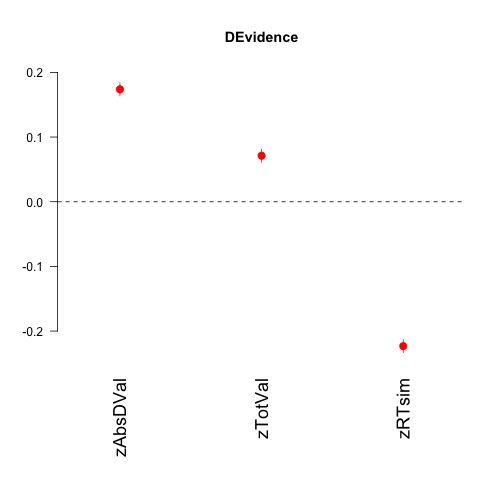

In [68]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

# We calculate the original regression with human data

In [69]:
%%R -i data_all
d <- data_all

BIC: 9752.417
Call:  glm(formula = zConf ~ zAbsDVal + zTotVal + zRT, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal          zRT  
    0.07449      0.14002      0.08652     -0.26744  

Degrees of Freedom: 3719 Total (i.e. Null);  3716 Residual
Null Deviance:	    3353 
Residual Deviance: 2964 	AIC: 9721


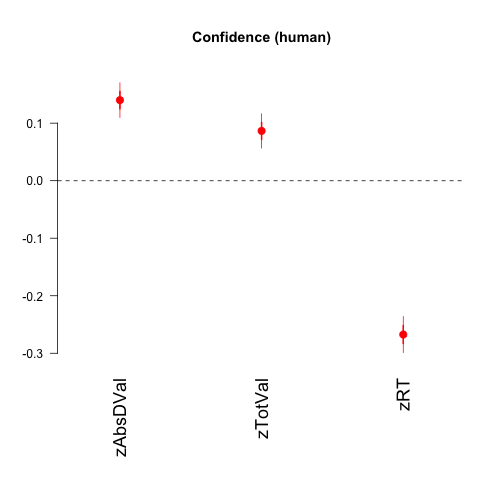

In [70]:
%%R    
title_plot = "Confidence (human)"
ModelChoice_1 <- glm(zConf ~ zAbsDVal + zTotVal + zRT  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

 ##  Data and simulations in figure

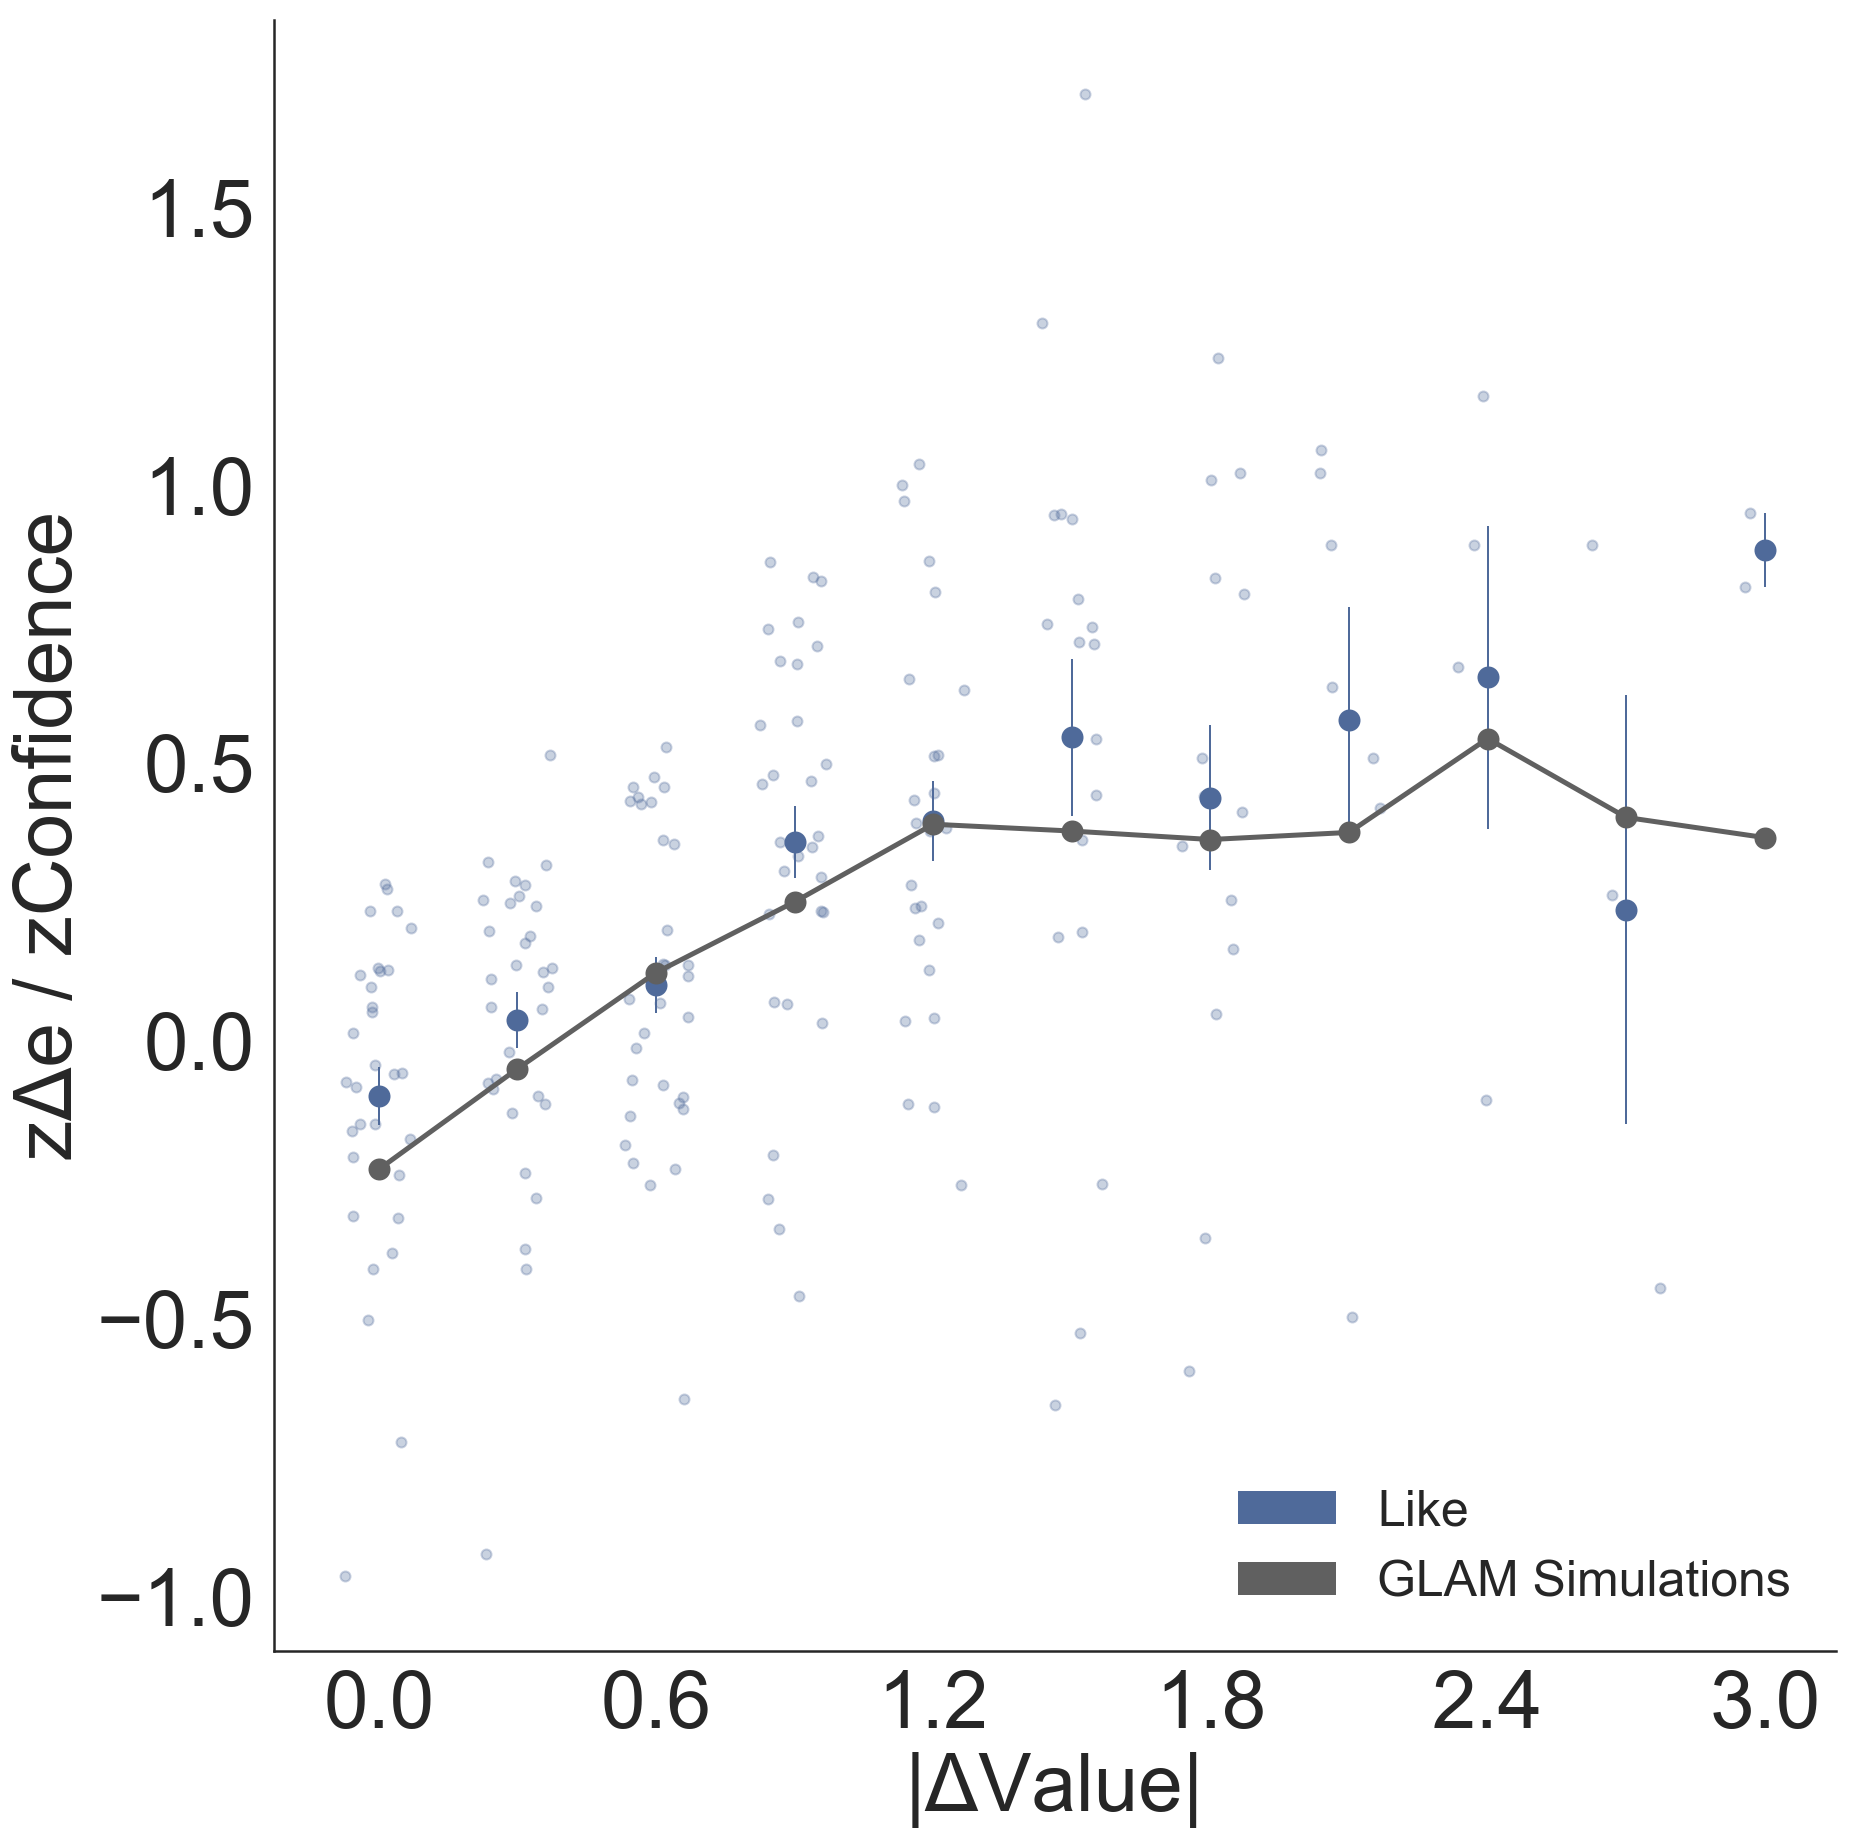

In [71]:
plot_DEv_Conf(data_simulation, xlabel_skip=2,color1 = '#4F6A9A')

Done with TotVal


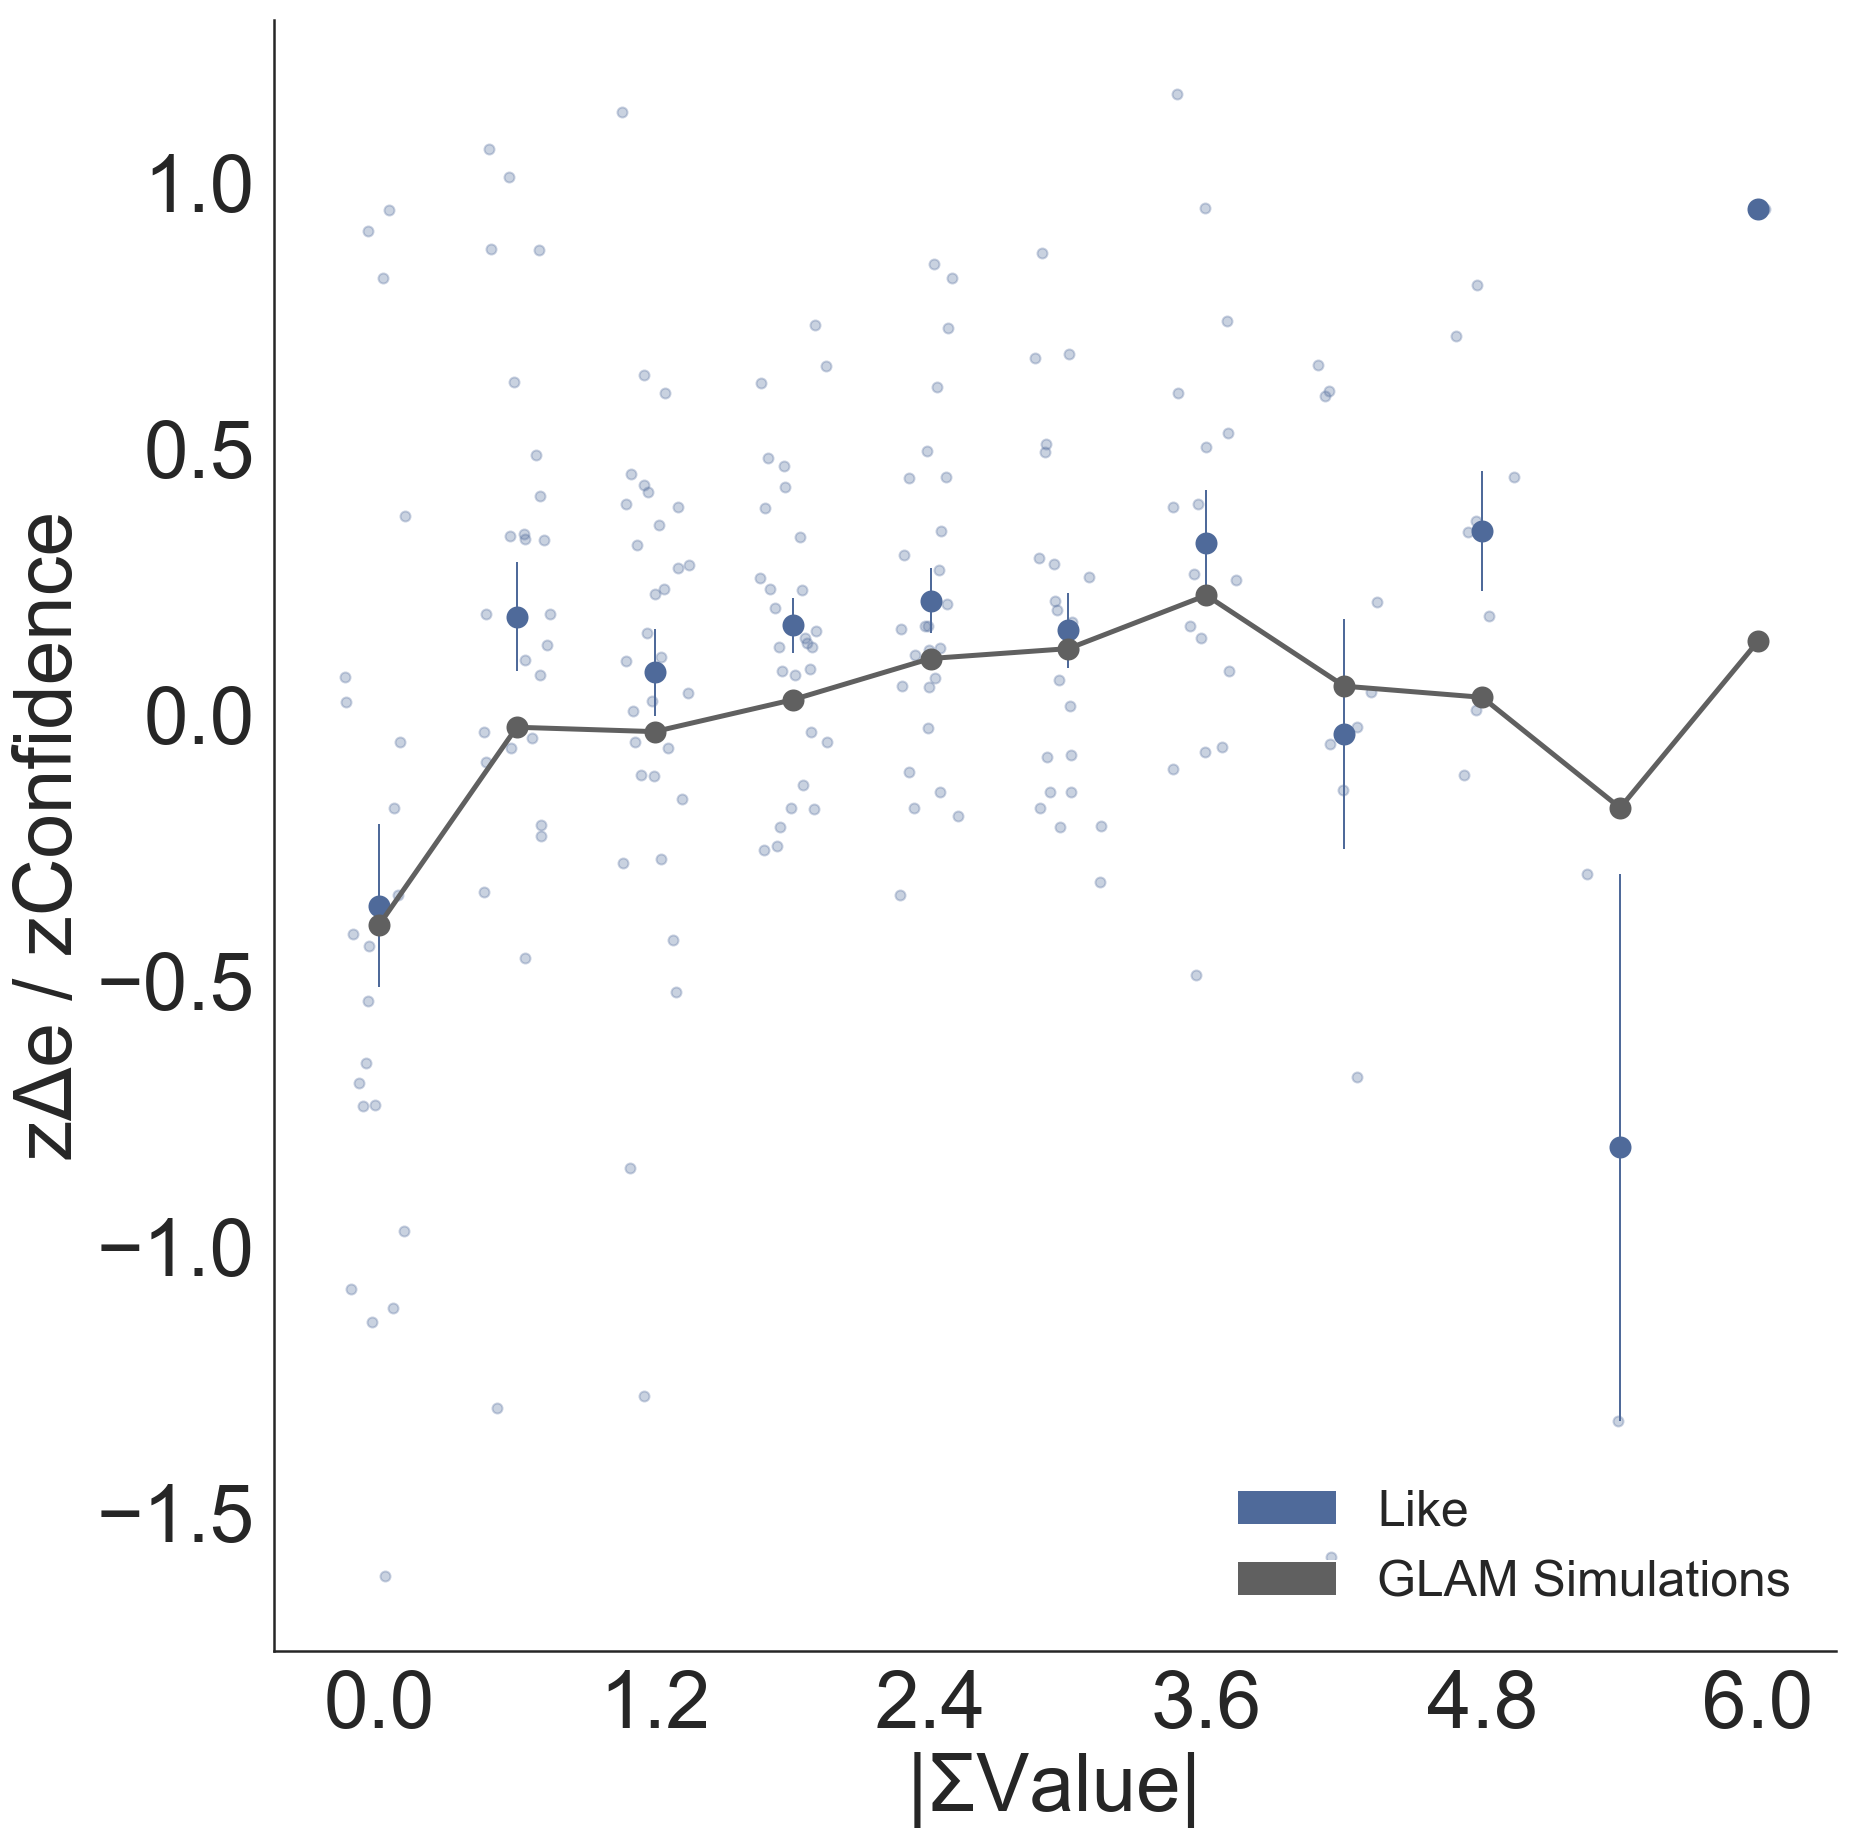

In [72]:
plot_DEv_Conf_TotVal(data_simulation,'TotVal', xlabel_skip=2,color1 = '#4F6A9A')

#  2. Excluding gaze information from the simulation 

In [73]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_'+sufix+'.csv')):  
        data_simulation2 = pd.read_csv(str('results/simulations_evidence/DEvidence_simulations_NoGaze_'+sufix+'.csv'))

In [74]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 1 # We DON'T want to use the gaze from the particpants

In [75]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_'+sufix+'.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    part_id = data_all['Part'].unique()
    
    for i in (data['subject'].unique()):    
        for k in range(0,repeat_extra) :
            PartData = data.loc[data['subject'] == i] # dataframe including participant GLAM data
            PartDataAll = data_all.loc[data_all['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
                gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
            
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])
                
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))

    data_simulation2 =  pd.DataFrame()
    
    data_simulation2["Part"] = Part_number
    data_simulation2["LVal"] = LVal
    data_simulation2["RVal"] = RVal
    data_simulation2["LGaze"] = LGaze
    data_simulation2["RGaze"] = RGaze
    data_simulation2["AbsDVal"] = absDVal
    data_simulation2["TotVal"] = TotVal
    data_simulation2["AbsDEv"] = AbsDEvid
    data_simulation2["RTsim"] = RT_sim
    data_simulation2["Correct_sim"] = Correct_sim
    data_simulation2["Choice_sim"] = Choice_sim
    data_simulation2["Conf_human"] = Conf_human
    data_simulation2["zConf_human"] = zConf_human
    
    data_simulation2["zLVal"] = z_score1(data_simulation2,'Part',"LVal")
    data_simulation2["zRVal"] = z_score1(data_simulation2,'Part',"RVal")
    data_simulation2["zAbsDVal"] = z_score1(data_simulation2,'Part',"AbsDVal")
    data_simulation2["zTotVal"] = z_score1(data_simulation2,'Part',"TotVal")
    data_simulation2["zAbsDEv"] = z_score1(data_simulation2,'Part',"AbsDEv")
    data_simulation2["zRTsim"] = z_score1(data_simulation2,'Part',"RTsim")

In [76]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_'+sufix+'.csv')):   
        data_simulation2.to_csv(str('results/simulations_evidence/DEvidence_simulations_NoGaze_'+sufix+'.csv'))

In [77]:
data_simulation2

,Unnamed: 0,Part,LVal,RVal,LGaze,RGaze,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,0,1.10,0.95,0.5,0.5,0.15,2.05,1.519714,3826.0,0,1.0,80,0.582155,-0.898735,-1.237881,-0.988498,-1.497033,2.134170,0.787661
1,1,0,2.00,1.70,0.5,0.5,0.30,3.70,0.621927,3727.0,1,0.0,78,0.432565,1.136137,0.457846,-0.570823,1.116834,-0.284400,0.703666
2,2,0,1.10,2.30,0.5,0.5,1.20,3.40,1.343064,2923.0,1,1.0,82,0.731746,-0.898735,1.814428,1.935228,0.641585,1.658287,0.021524
3,3,0,1.25,1.40,0.5,0.5,0.15,2.65,0.558063,4331.0,0,0.0,42,-2.260059,-0.559590,-0.220445,-0.988498,-0.546536,-0.456444,1.216121
4,4,0,2.00,2.30,0.5,0.5,0.30,4.30,0.604166,3243.0,1,1.0,70,-0.165796,1.136137,1.814428,-0.570823,2.067331,-0.332247,0.293023
5,5,0,1.70,1.85,0.5,0.5,0.15,3.55,0.984522,3365.0,1,1.0,74,0.133385,0.457846,0.796992,-0.988498,0.879210,0.692402,0.396532
6,6,0,1.85,0.65,0.5,0.5,1.20,2.50,1.233709,1839.0,1,0.0,70,-0.165796,0.796992,-1.916172,1.935228,-0.784160,1.363692,-0.898179
7,7,0,1.55,0.80,0.5,0.5,0.75,2.35,1.282036,2991.0,1,0.0,76,0.282975,0.118701,-1.577026,0.682203,-1.021784,1.493882,0.079218
8,8,0,1.55,1.10,0.5,0.5,0.45,2.65,0.709792,2349.0,1,0.0,90,1.330107,0.118701,-0.898735,-0.153148,-0.546536,-0.047699,-0.465478
9,9,0,1.10,2.00,0.5,0.5,0.90,3.10,0.838071,3562.0,1,1.0,54,-1.362518,-0.898735,1.136137,1.099878,0.166337,0.297875,0.563674


In [79]:
%%R -i data_simulation2
d <- data_simulation2

BIC: 101554.4
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal + zRTsim, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal       zRTsim  
 -7.012e-16    2.138e-01   -7.468e-03   -2.102e-01  

Degrees of Freedom: 37199 Total (i.e. Null);  37196 Residual
Null Deviance:	    37200 
Residual Deviance: 33350 	AIC: 101500


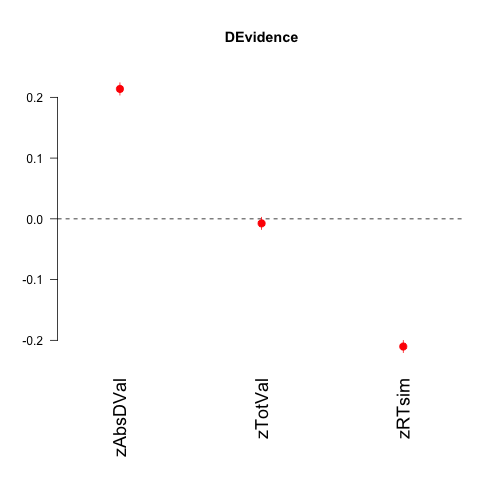

In [80]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

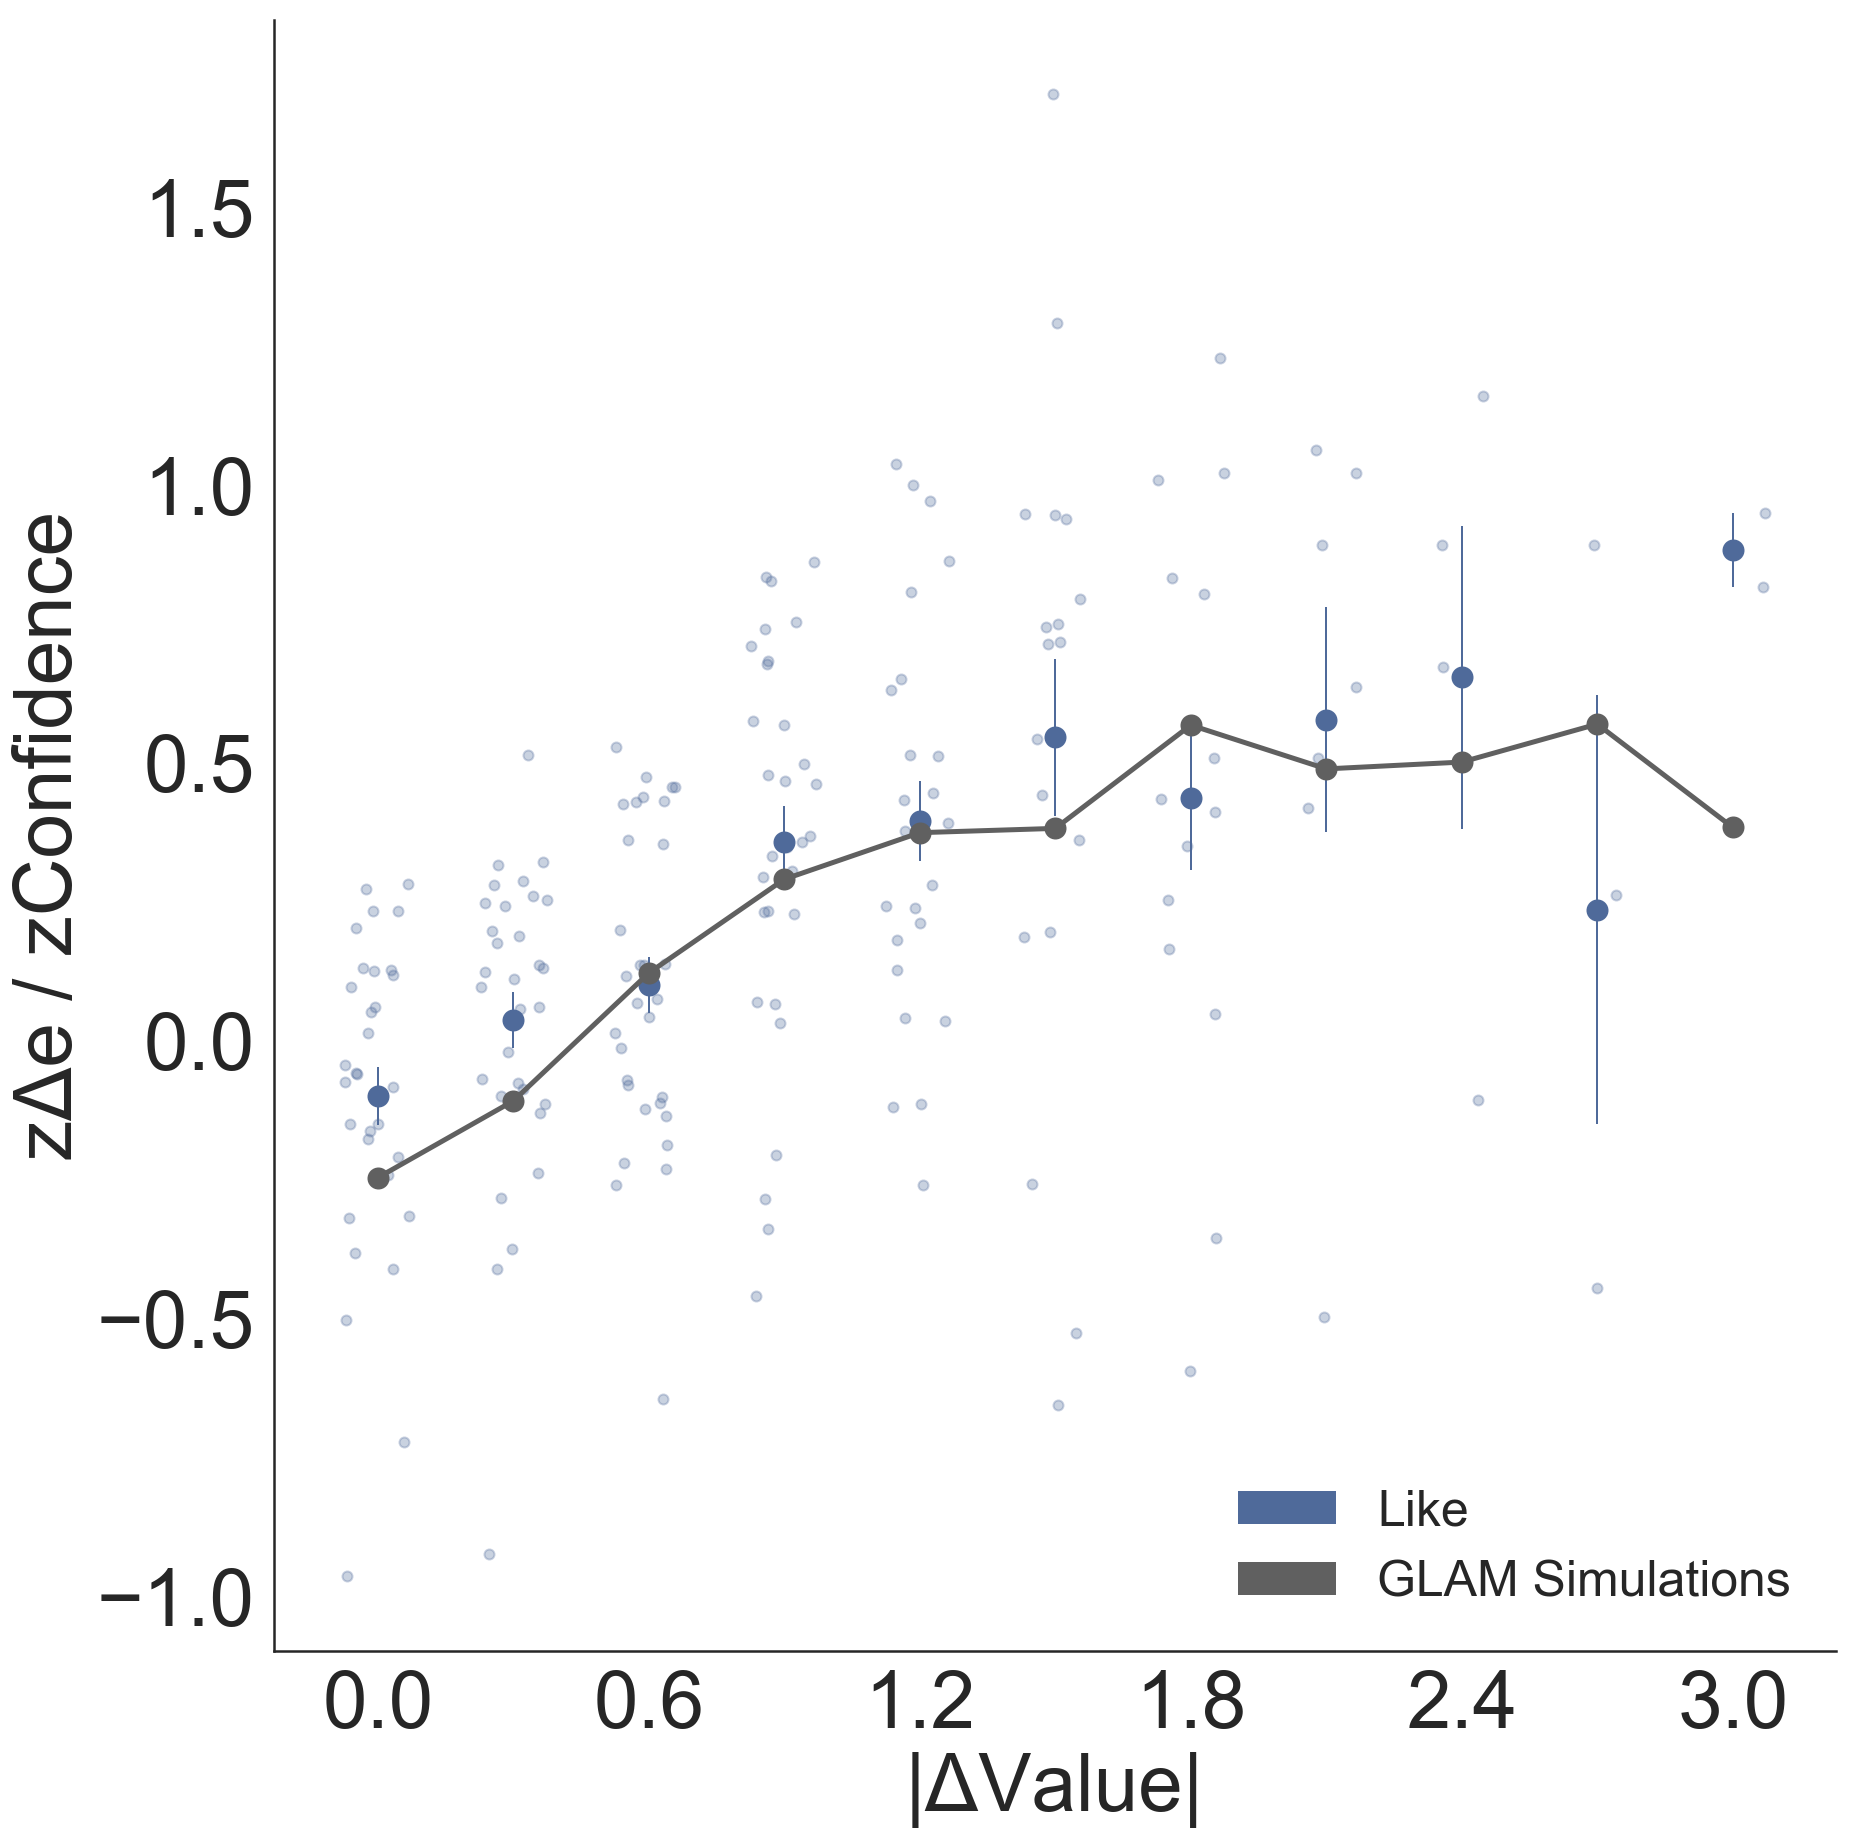

In [81]:
plot_DEv_Conf(data_simulation2, xlabel_skip=2,color1 = '#4F6A9A')

Done with TotVal


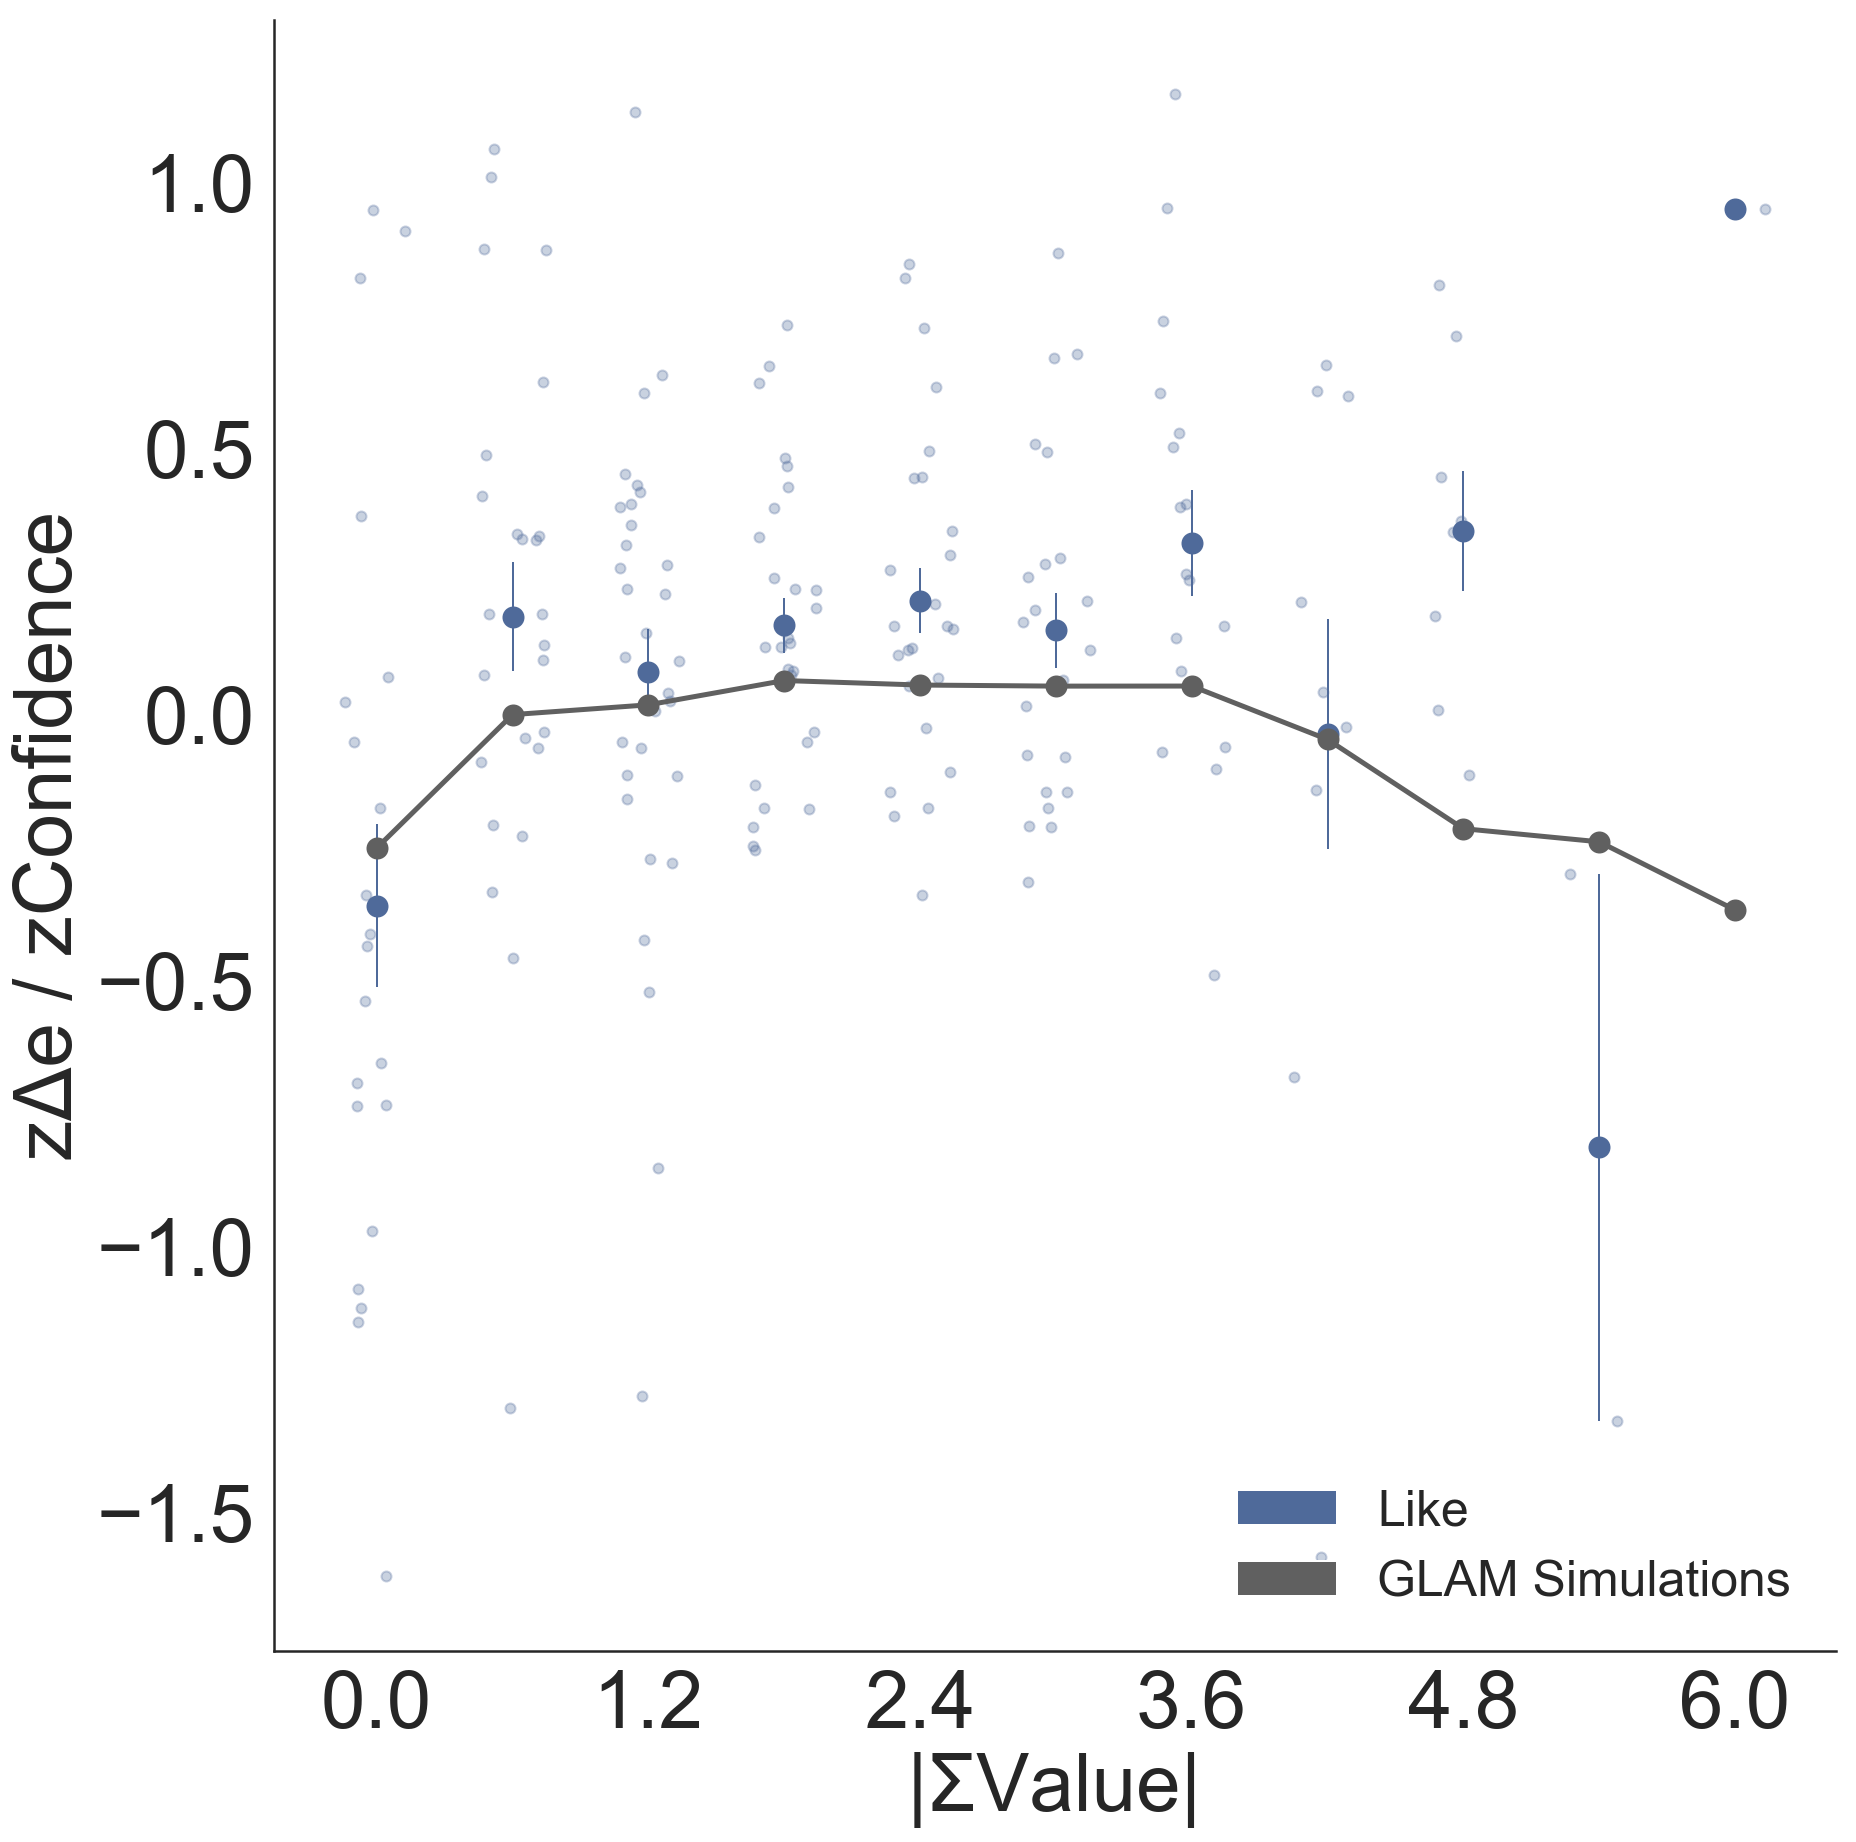

In [82]:
plot_DEv_Conf_TotVal(data_simulation2,'TotVal', xlabel_skip=2,color1 = '#4F6A9A')

- ---- -----------------------------------------------------------------------------------

# Dislike frame


## Load parameter estimates for participants


Use the parameter estimates from GLAM fit for Like, Binned data

In [83]:
sufix = 'individual_Dislike_Inv_NoBin_Gamma-11_NUTS_31'
glam_full = glam.GLAM(data)
glam_full.estimates = np.load(str('results/estimates/glam_FF2019_full_'+sufix+'.npy'))

# generate dataframe with new params
params_part_l = pd.DataFrame()
for i in range(len(glam_full.estimates)):    
    params_part_l1 = pd.DataFrame.from_dict(glam_full.estimates.item(i))
    params_part_l = pd.concat([params_part_l ,params_part_l1])
    
params_part_l = params_part_l.reset_index(drop=True)

params_part = params_part_l
params_part



,b,p_error,v,gamma,SNR,s,tau,t0
0,1.0,0.05,0.000037,0.62,180.28,0.006407,3.56,0.0
1,1.0,0.05,0.000049,0.43,37.53,0.004241,0.45,0.0
2,1.0,0.05,0.000044,0.99,146.71,0.007717,0.80,0.0
3,1.0,0.05,0.000036,0.16,183.63,0.007155,3.00,0.0
4,1.0,0.05,0.000048,0.36,214.51,0.009292,4.92,0.0
5,1.0,0.05,0.000045,0.29,210.12,0.008504,4.76,0.0
6,1.0,0.05,0.000063,0.27,132.99,0.008919,1.27,0.0
7,1.0,0.05,0.000042,-0.06,139.13,0.006858,4.19,0.0
8,1.0,0.05,0.000047,-0.98,167.29,0.008069,2.58,0.0
9,1.0,0.05,0.000052,-0.69,122.06,0.006391,4.85,0.0


# Run drift simulations for selected values and parameters

#  1. Including gaze information in the simulation 

In [84]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv')):  
        data_simulation = pd.read_csv(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv'))

In [85]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 0 # We DO want to use the gaze from the particpants

In [86]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    part_id = data_all2['Part'].unique()
    
    for i in (data2['subject'].unique()):    
        for k in range(0,repeat_extra) :
            PartData = data2.loc[data2['subject'] == i] # dataframe including participant GLAM data
            PartDataAll = data_all2.loc[data_all2['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
                gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
                
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])
            
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))
        
    data_simulation =  pd.DataFrame()
    data_simulation["Part"] = Part_number
    data_simulation["LVal"] = LVal
    data_simulation["RVal"] = RVal
    data_simulation["LGaze"] = LGaze
    data_simulation["RGaze"] = RGaze
    data_simulation["AbsDVal"] = absDVal
    data_simulation["TotVal"] = TotVal
    data_simulation["AbsDEv"] = AbsDEvid
    data_simulation["RTsim"] = RT_sim
    data_simulation["Correct_sim"] = Correct_sim
    data_simulation["Choice_sim"] = Choice_sim
    data_simulation["Conf_human"] = Conf_human
    data_simulation["zConf_human"] = zConf_human
    
    data_simulation["zLVal"] = z_score1(data_simulation,'Part',"LVal")
    data_simulation["zRVal"] = z_score1(data_simulation,'Part',"RVal")
    data_simulation["zAbsDVal"] = z_score1(data_simulation,'Part',"AbsDVal")
    data_simulation["zTotVal"] = z_score1(data_simulation,'Part',"TotVal")
    data_simulation["zAbsDEv"] = z_score1(data_simulation,'Part',"AbsDEv")
    data_simulation["zRTsim"] = z_score1(data_simulation,'Part',"RTsim")

In [87]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv')):   
        data_simulation.to_csv(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv'))

In [88]:
data_simulation

,Unnamed: 0,Part,LVal,RVal,LGaze,RGaze,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,0,2.05,1.00,0.745415,0.254585,1.05,3.05,0.882675,5775.0,1,0.0,72,-0.016206,1.237881,-1.136137,1.517553,0.071287,0.323846,1.962973
1,1,0,0.70,1.30,0.410720,0.589280,0.60,2.00,1.116604,3469.0,1,1.0,68,-0.315386,-1.814428,-0.457846,0.264528,-1.592082,0.966795,0.109490
2,2,0,1.30,1.75,0.330549,0.669451,0.45,3.05,0.932064,3864.0,1,1.0,68,-0.315386,-0.457846,0.559590,-0.153148,0.071287,0.459590,0.426977
3,3,0,1.45,0.70,0.592345,0.407655,0.75,2.15,1.306198,1891.0,1,0.0,68,-0.315386,-0.118701,-1.814428,0.682203,-1.354458,1.487889,-1.158853
4,4,0,1.00,1.00,0.641717,0.358283,0.00,2.00,0.568219,5356.0,0,1.0,88,1.180516,-1.136137,-1.136137,-1.406173,-1.592082,-0.540429,1.626196
5,5,0,2.35,1.75,0.744016,0.255984,0.60,4.10,1.111494,2301.0,1,0.0,86,1.030926,1.916172,0.559590,0.264528,1.734657,0.952751,-0.829309
6,6,0,1.45,1.90,0.329730,0.670270,0.45,3.35,0.841895,4794.0,1,1.0,78,0.432565,-0.118701,0.898735,-0.153148,0.546536,0.211762,1.174479
7,7,0,2.05,2.35,0.363897,0.636103,0.30,4.40,0.712930,3812.0,1,1.0,72,-0.016206,1.237881,1.916172,-0.570823,2.209905,-0.142695,0.385181
8,8,0,1.45,1.30,0.419431,0.580569,0.15,2.75,0.156379,5324.0,1,0.0,68,-0.315386,-0.118701,-0.457846,-0.988498,-0.403961,-1.672362,1.600475
9,9,0,1.00,1.90,0.169957,0.830043,0.90,2.90,1.303793,2792.0,1,1.0,66,-0.464976,-1.136137,0.898735,1.099878,-0.166337,1.481278,-0.434660


## Since for dislike we have that TotVal represents the inverted value we take it back to the original denomination

In [89]:
data_simulation['TotVal_orig'] = 6 - data_simulation['TotVal']
data_simulation["zTotVal_orig"] = z_score1(data_simulation,'Part',"TotVal_orig")


In [91]:
%%R -i data_simulation
d <- data_simulation

BIC: 103605.9
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal_orig + zRTsim, data = d)

Coefficients:
 (Intercept)      zAbsDVal  zTotVal_orig        zRTsim  
   6.571e-17     1.263e-01    -5.201e-02    -1.775e-01  

Degrees of Freedom: 37199 Total (i.e. Null);  37196 Residual
Null Deviance:	    37200 
Residual Deviance: 35240 	AIC: 103600


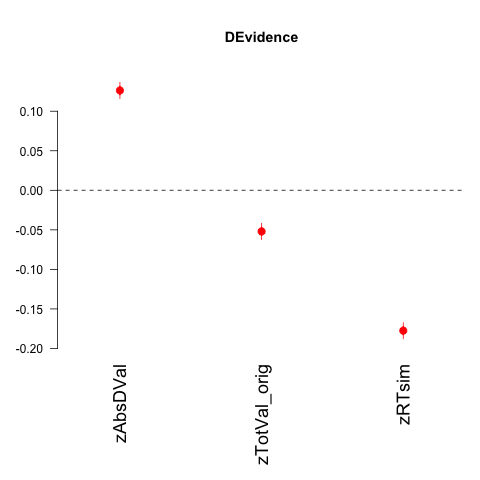

In [92]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal_orig + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

# We calculate the original regression with human data

In [93]:
%%R -i data_all2
d <- data_all2

BIC: 10216.38
Call:  glm(formula = zConf ~ zAbsDVal + zTotVal + zRT, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal          zRT  
   -0.07089      0.18816     -0.15851     -0.30716  

Degrees of Freedom: 3719 Total (i.e. Null);  3716 Residual
Null Deviance:	    4019 
Residual Deviance: 3357 	AIC: 10190


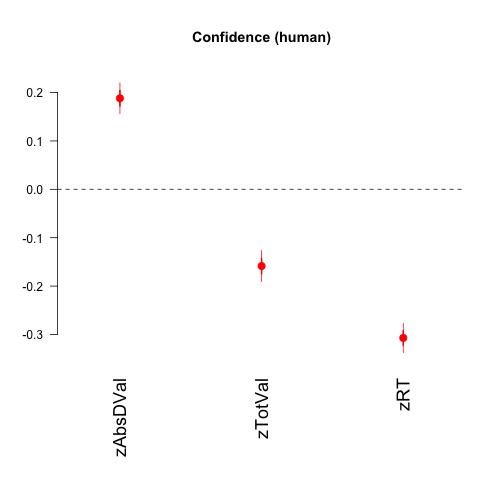

In [94]:
%%R    
title_plot = "Confidence (human)"
ModelChoice_1 <- glm(zConf ~ zAbsDVal + zTotVal + zRT  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

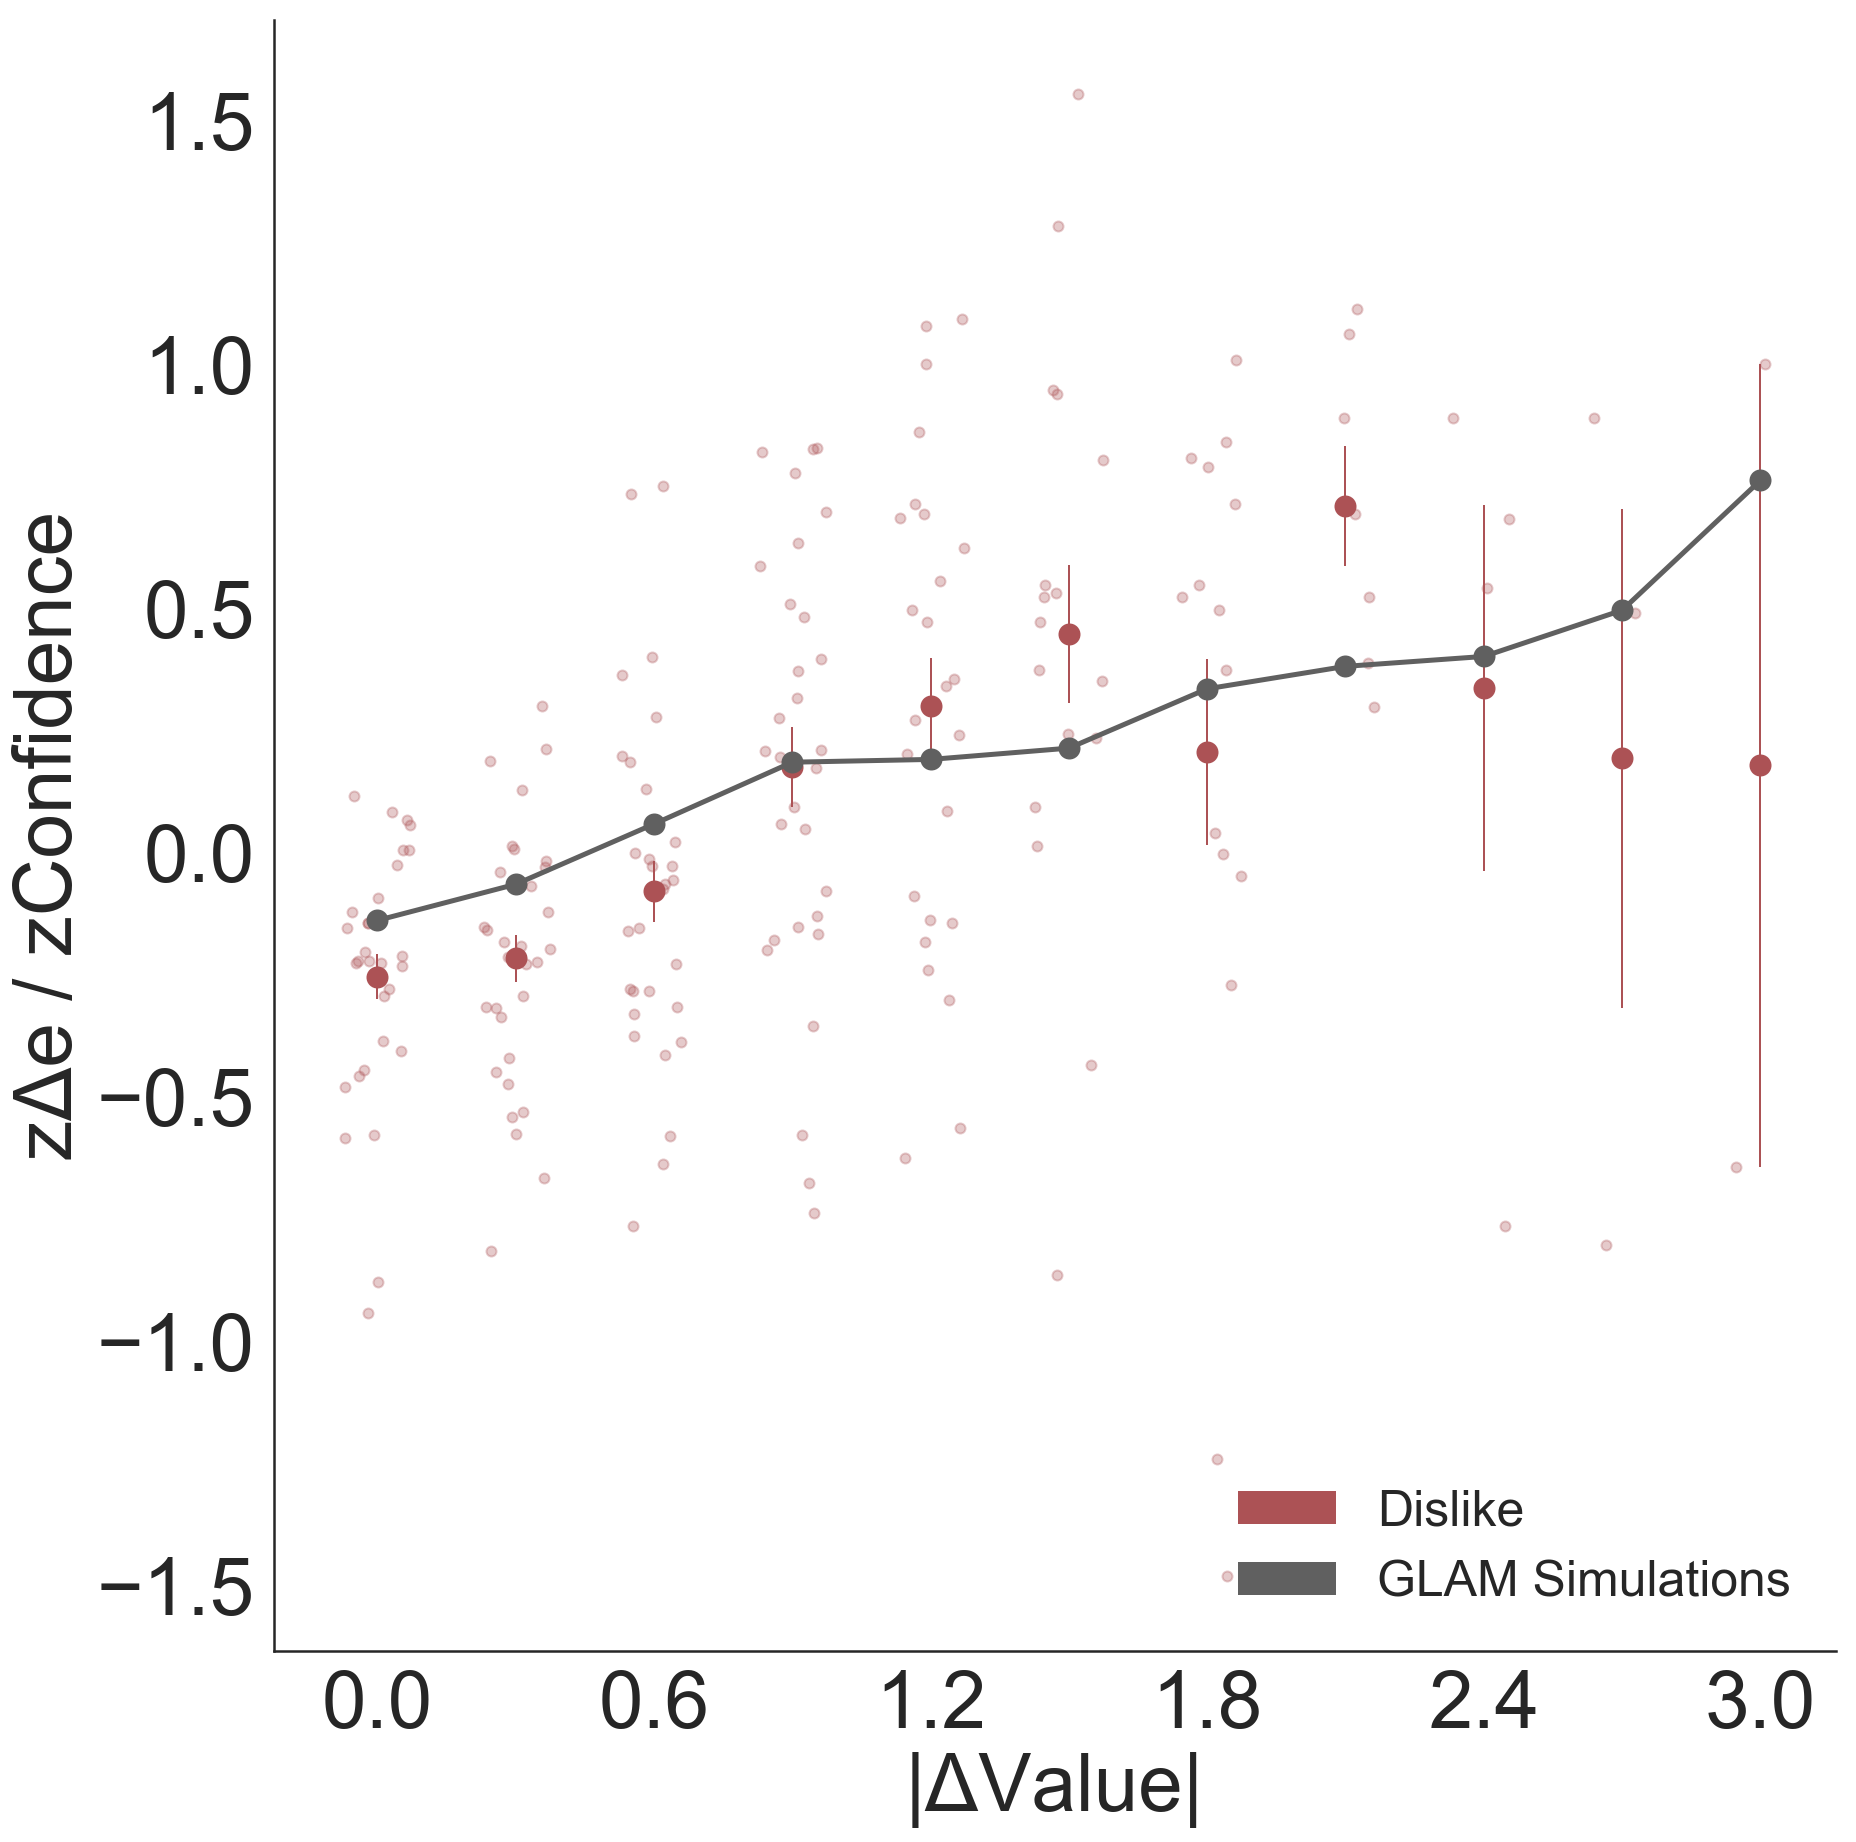

In [95]:
plot_DEv_Conf(data_simulation, xlabel_skip=2,color1 = '#AC5255',label1 = 'Dislike')

In [96]:
data_simulation

,Unnamed: 0,Part,LVal,RVal,LGaze,RGaze,AbsDVal,TotVal,AbsDEv,RTsim,...,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim,TotVal_orig,zTotVal_orig
0,0,0,2.05,1.00,0.745415,0.254585,1.05,3.05,0.882675,5775.0,...,72,-0.016206,1.237881,-1.136137,1.517553,0.071287,0.323846,1.962973,2.95,-0.071287
1,1,0,0.70,1.30,0.410720,0.589280,0.60,2.00,1.116604,3469.0,...,68,-0.315386,-1.814428,-0.457846,0.264528,-1.592082,0.966795,0.109490,4.00,1.592082
2,2,0,1.30,1.75,0.330549,0.669451,0.45,3.05,0.932064,3864.0,...,68,-0.315386,-0.457846,0.559590,-0.153148,0.071287,0.459590,0.426977,2.95,-0.071287
3,3,0,1.45,0.70,0.592345,0.407655,0.75,2.15,1.306198,1891.0,...,68,-0.315386,-0.118701,-1.814428,0.682203,-1.354458,1.487889,-1.158853,3.85,1.354458
4,4,0,1.00,1.00,0.641717,0.358283,0.00,2.00,0.568219,5356.0,...,88,1.180516,-1.136137,-1.136137,-1.406173,-1.592082,-0.540429,1.626196,4.00,1.592082
5,5,0,2.35,1.75,0.744016,0.255984,0.60,4.10,1.111494,2301.0,...,86,1.030926,1.916172,0.559590,0.264528,1.734657,0.952751,-0.829309,1.90,-1.734657
6,6,0,1.45,1.90,0.329730,0.670270,0.45,3.35,0.841895,4794.0,...,78,0.432565,-0.118701,0.898735,-0.153148,0.546536,0.211762,1.174479,2.65,-0.546536
7,7,0,2.05,2.35,0.363897,0.636103,0.30,4.40,0.712930,3812.0,...,72,-0.016206,1.237881,1.916172,-0.570823,2.209905,-0.142695,0.385181,1.60,-2.209905
8,8,0,1.45,1.30,0.419431,0.580569,0.15,2.75,0.156379,5324.0,...,68,-0.315386,-0.118701,-0.457846,-0.988498,-0.403961,-1.672362,1.600475,3.25,0.403961
9,9,0,1.00,1.90,0.169957,0.830043,0.90,2.90,1.303793,2792.0,...,66,-0.464976,-1.136137,0.898735,1.099878,-0.166337,1.481278,-0.434660,3.10,0.166337


Done with TotVal


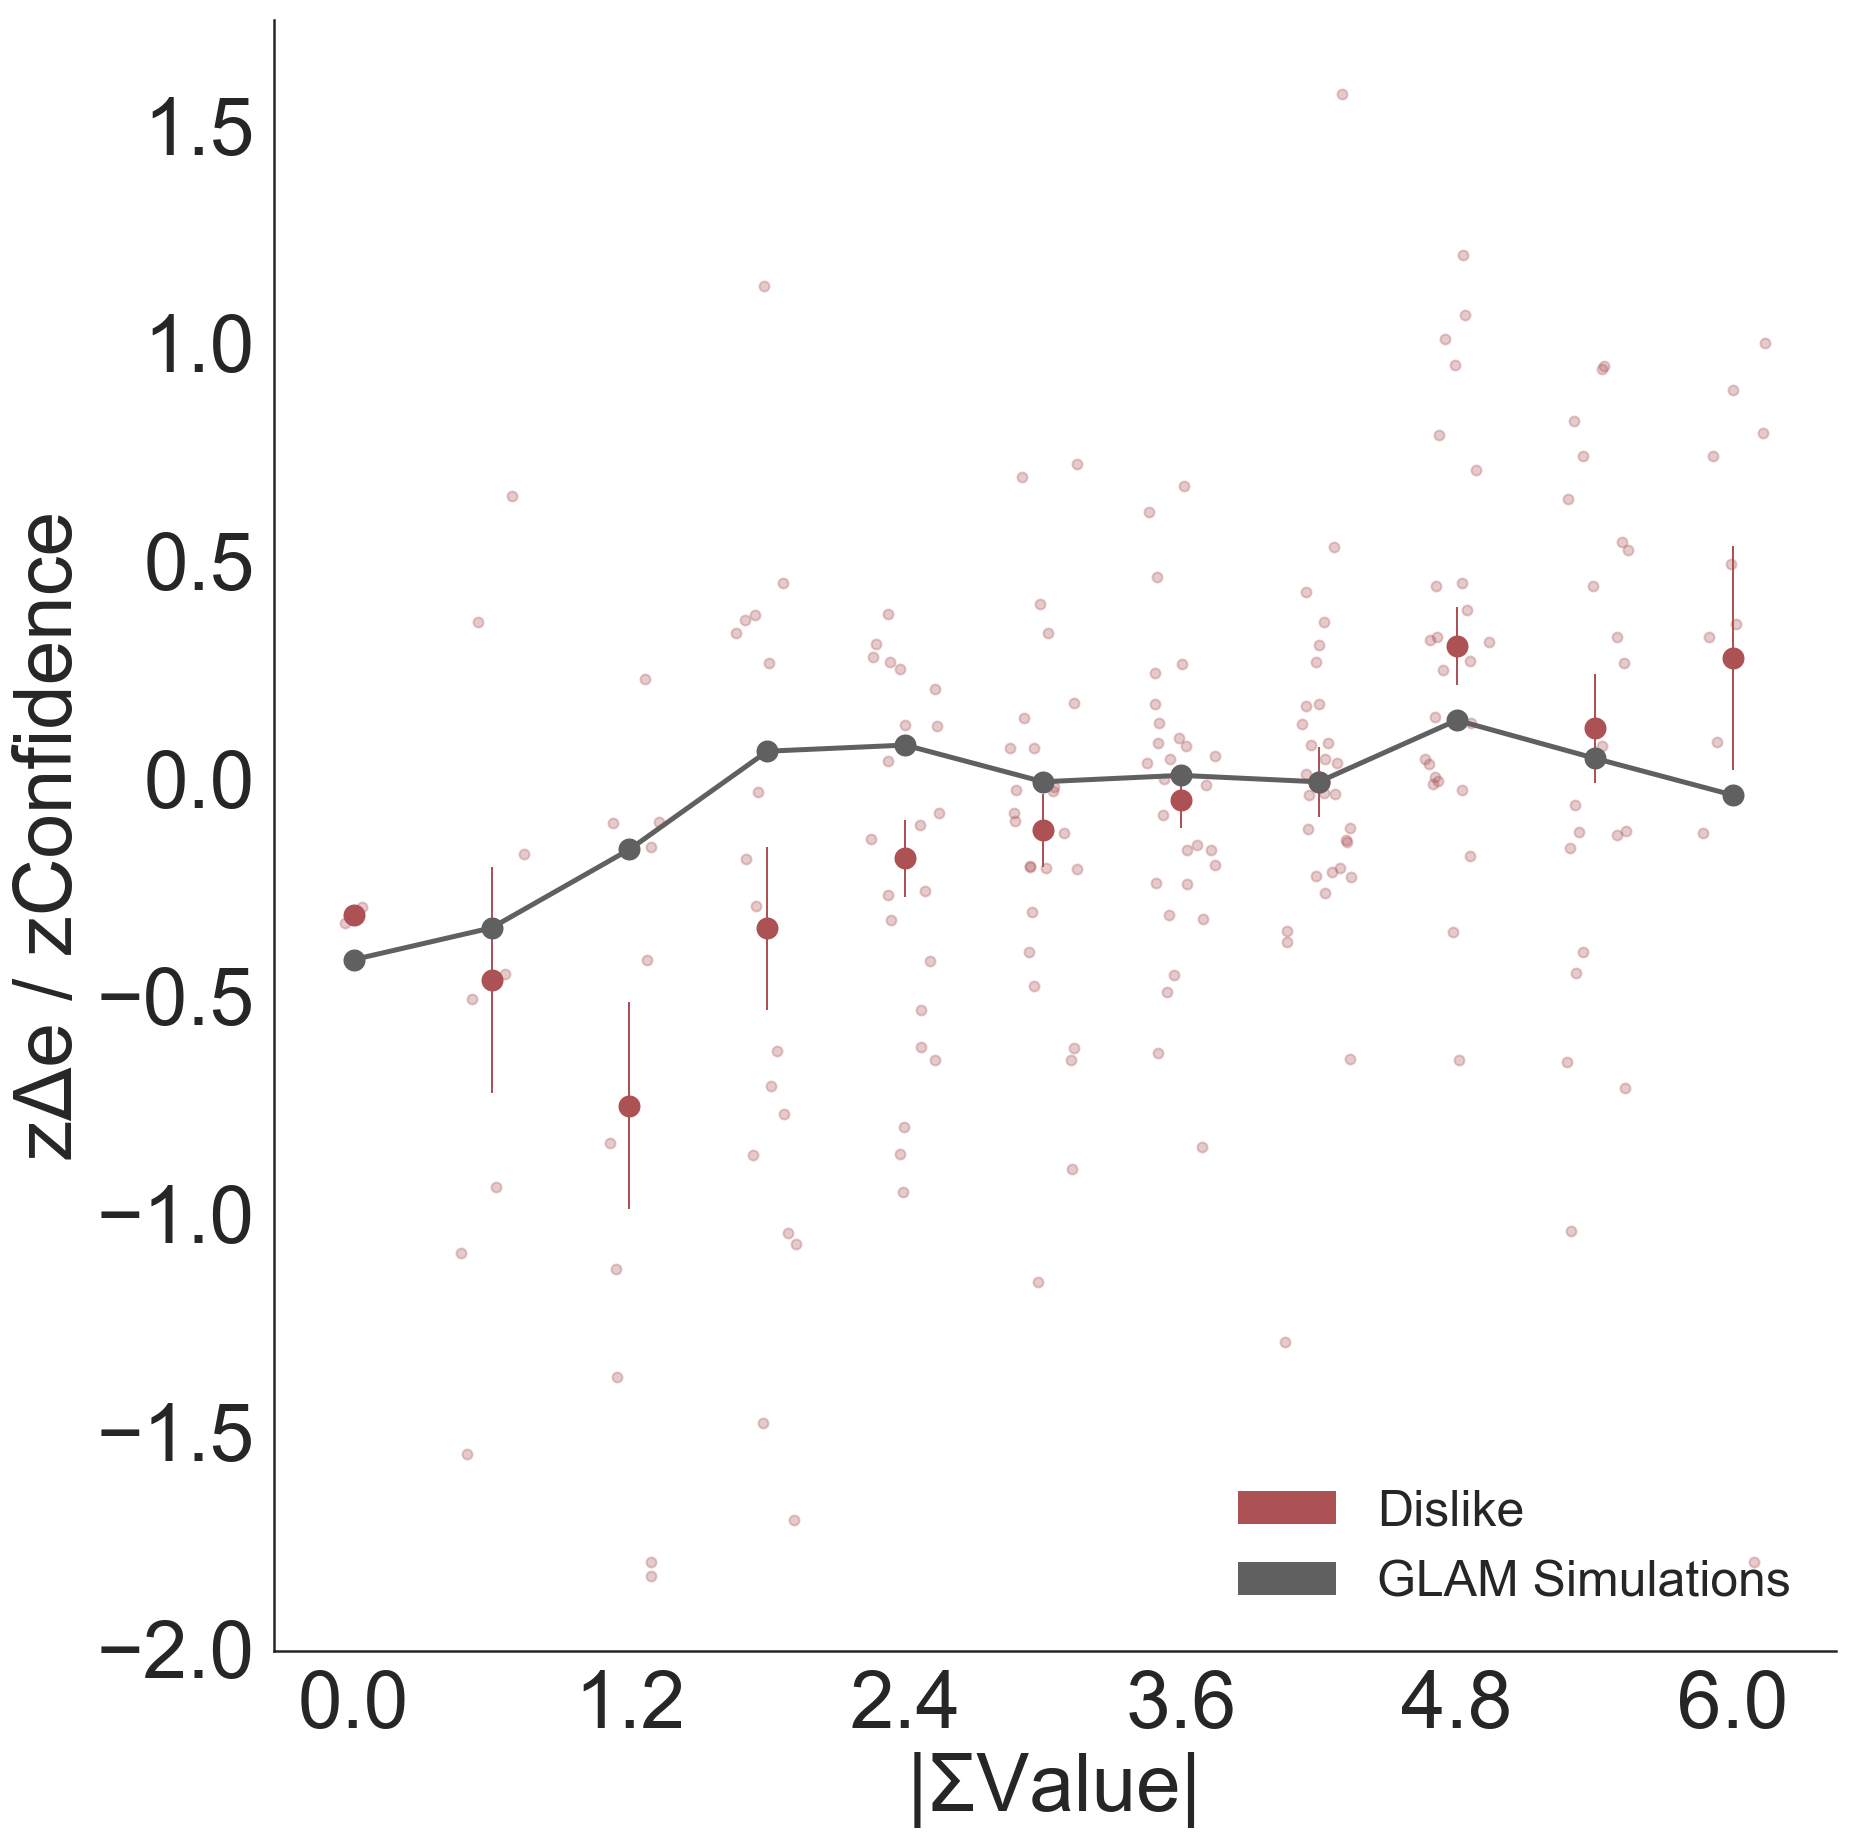

In [97]:
plot_DEv_Conf_TotVal(data_simulation,'TotVal', xlabel_skip=2,color1 = '#AC5255',label1 = 'Dislike')

Done with TotVal


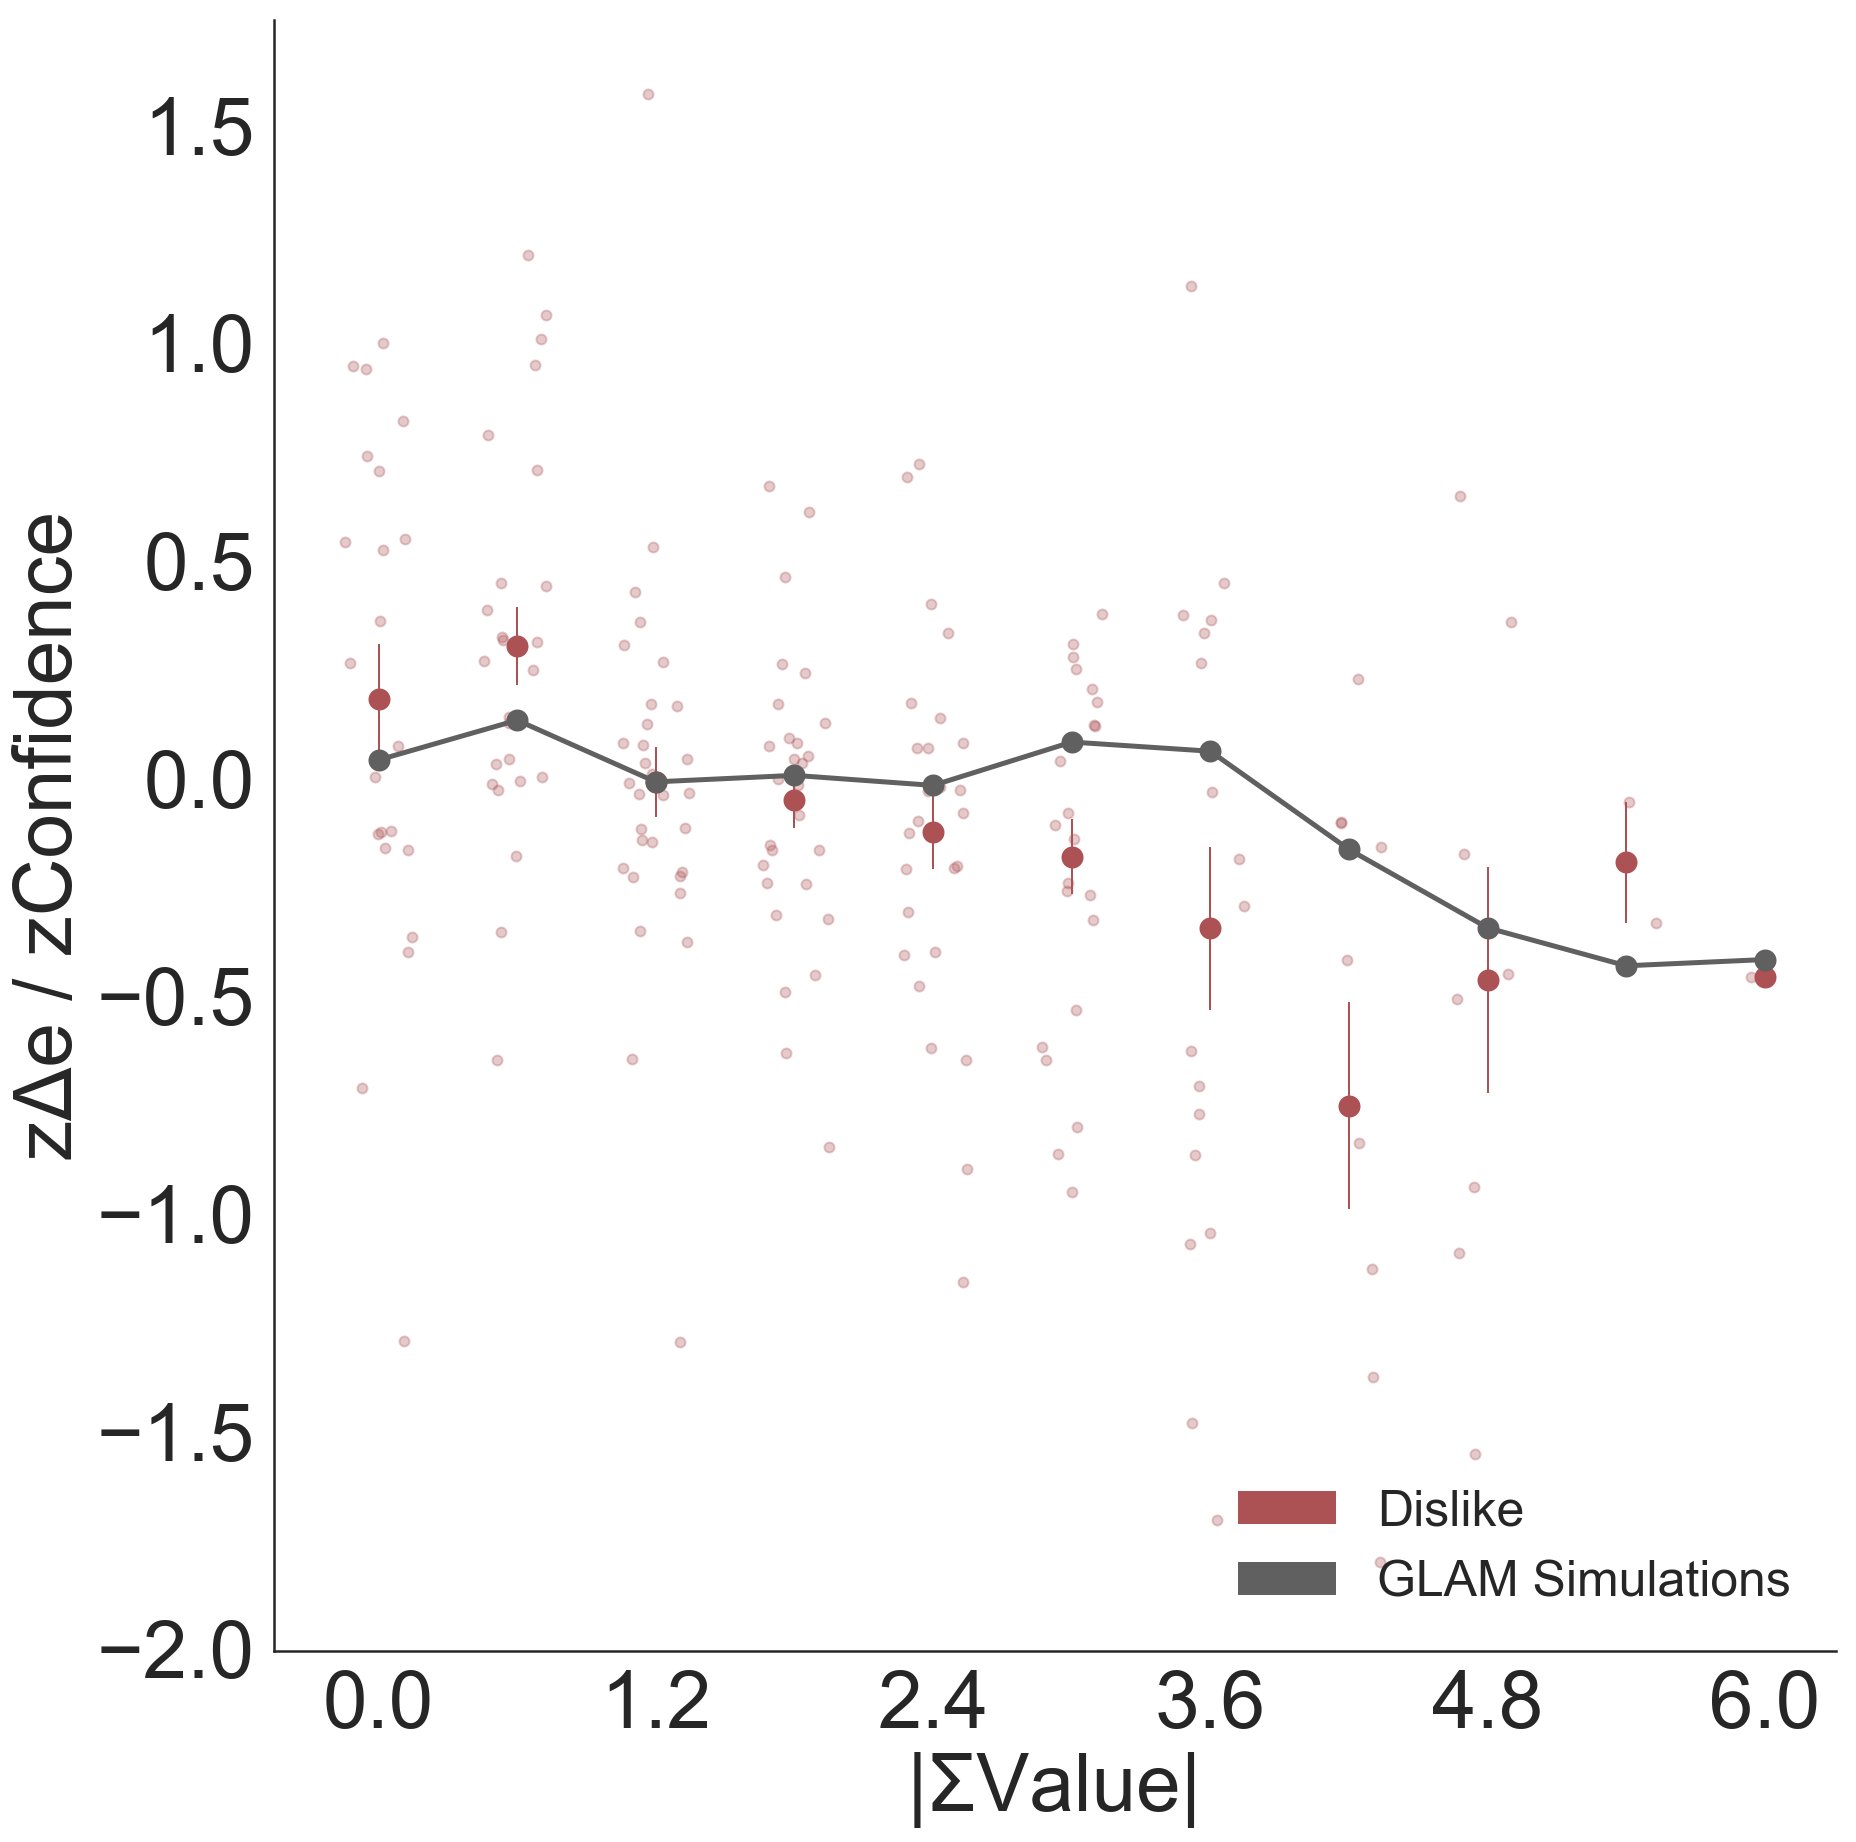

In [98]:
plot_DEv_Conf_TotVal(data_simulation,'TotVal_orig', xlabel_skip=2,color1 = '#AC5255',label1 = 'Dislike')

#  2. Excluding gaze information in the simulation 

In [99]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_'+sufix+'.csv')):  
        data_simulation2 = pd.read_csv(str('results/simulations_evidence/DEvidence_simulations_NoGaze_'+sufix+'.csv'))

In [100]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 1 # We DON'T want to use the gaze from the particpants

In [101]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_'+sufix+'.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    value_tests = []
    gaze_tests = []
    
    part_id = data_all2['Part'].unique()
    
    for i in (data2['subject'].unique()):    
        for k in range(0,repeat_extra) :
            PartData = data2.loc[data2['subject'] == i] # dataframe including participant GLAM data
            PartDataAll = data_all2.loc[data_all2['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
              #  gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))
                gaze_tests = [0, 0] # To test why it's crashing

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
            
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])

                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))

    data_simulation2 =  pd.DataFrame()
    
    data_simulation2["Part"] = Part_number
    data_simulation2["LVal"] = LVal
    data_simulation2["RVal"] = RVal
    data_simulation2["LGaze"] = LGaze
    data_simulation2["RGaze"] = RGaze
    data_simulation2["AbsDVal"] = absDVal
    data_simulation2["TotVal"] = TotVal
    data_simulation2["AbsDEv"] = AbsDEvid
    data_simulation2["RTsim"] = RT_sim
    data_simulation2["Correct_sim"] = Correct_sim
    data_simulation2["Choice_sim"] = Choice_sim
    data_simulation2["Conf_human"] = Conf_human
    data_simulation2["zConf_human"] = zConf_human
    

In [102]:
data_simulation2["zLVal"] = z_score1(data_simulation2,'Part',"LVal")
data_simulation2["zRVal"] = z_score1(data_simulation2,'Part',"RVal")
data_simulation2["zAbsDVal"] = z_score1(data_simulation2,'Part',"AbsDVal")
data_simulation2["zTotVal"] = z_score1(data_simulation2,'Part',"TotVal")
data_simulation2["zAbsDEv"] = z_score1(data_simulation2,'Part',"AbsDEv")
data_simulation2["zRTsim"] = z_score1(data_simulation2,'Part',"RTsim")

In [103]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_'+sufix+'.csv')):   
        data_simulation2.to_csv(str('results/simulations_evidence/DEvidence_simulations_NoGaze_'+sufix+'.csv'))

In [104]:
data_simulation2

,Unnamed: 0,Part,LVal,RVal,LGaze,RGaze,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,0,2.05,1.00,0.5,0.5,1.05,3.05,1.670773,4361.0,1,0.0,72,-0.016206,1.237881,-1.136137,1.517553,0.071287,2.542625,0.668519
1,1,0,0.70,1.30,0.5,0.5,0.60,2.00,0.656735,2938.0,1,1.0,68,-0.315386,-1.814428,-0.457846,0.264528,-1.592082,-0.236878,-0.379041
2,2,0,1.30,1.75,0.5,0.5,0.45,3.05,1.151043,2637.0,1,1.0,68,-0.315386,-0.457846,0.559590,-0.153148,0.071287,1.118032,-0.600626
3,3,0,1.45,0.70,0.5,0.5,0.75,2.15,0.752506,5080.0,1,0.0,68,-0.315386,-0.118701,-1.814428,0.682203,-1.354458,0.025632,1.197821
4,4,0,1.00,1.00,0.5,0.5,0.00,2.00,0.500013,2740.0,0,0.0,88,1.180516,-1.136137,-1.136137,-1.406173,-1.592082,-0.666457,-0.524802
5,5,0,2.35,1.75,0.5,0.5,0.60,4.10,1.076115,3264.0,1,0.0,86,1.030926,1.916172,0.559590,0.264528,1.734657,0.912653,-0.139052
6,6,0,1.45,1.90,0.5,0.5,0.45,3.35,1.466680,3542.0,1,1.0,78,0.432565,-0.118701,0.898735,-0.153148,0.546536,1.983201,0.065601
7,7,0,2.05,2.35,0.5,0.5,0.30,4.40,0.801232,2166.0,1,1.0,72,-0.016206,1.237881,1.916172,-0.570823,2.209905,0.159192,-0.947359
8,8,0,1.45,1.30,0.5,0.5,0.15,2.75,0.397058,4616.0,1,0.0,68,-0.315386,-0.118701,-0.457846,-0.988498,-0.403961,-0.948660,0.856241
9,9,0,1.00,1.90,0.5,0.5,0.90,2.90,0.777831,1917.0,1,1.0,66,-0.464976,-1.136137,0.898735,1.099878,-0.166337,0.095049,-1.130664


## Since for dislike we have that TotVal represents the inverted value we take it back to the original denomination

In [105]:
data_simulation2['TotVal_orig'] = 6 - data_simulation2['TotVal']
data_simulation2["zTotVal_orig"] = z_score1(data_simulation2,'Part',"TotVal_orig")

In [107]:
%%R -i data_simulation2
d <- data_simulation2

BIC: 102320.9
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal_orig + zRTsim, data = d)

Coefficients:
 (Intercept)      zAbsDVal  zTotVal_orig        zRTsim  
  -2.887e-16     2.021e-01     1.050e-02    -1.777e-01  

Degrees of Freedom: 37199 Total (i.e. Null);  37196 Residual
Null Deviance:	    37200 
Residual Deviance: 34040 	AIC: 102300


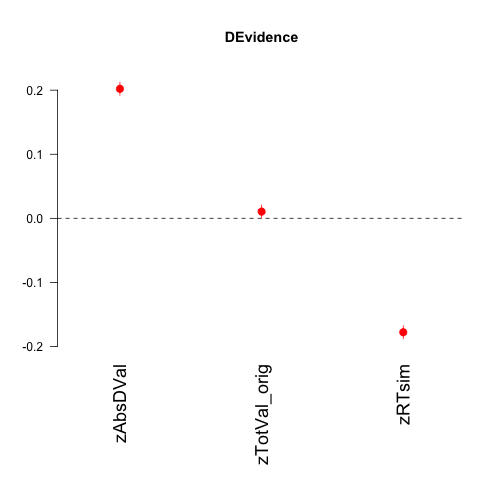

In [108]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal_orig + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

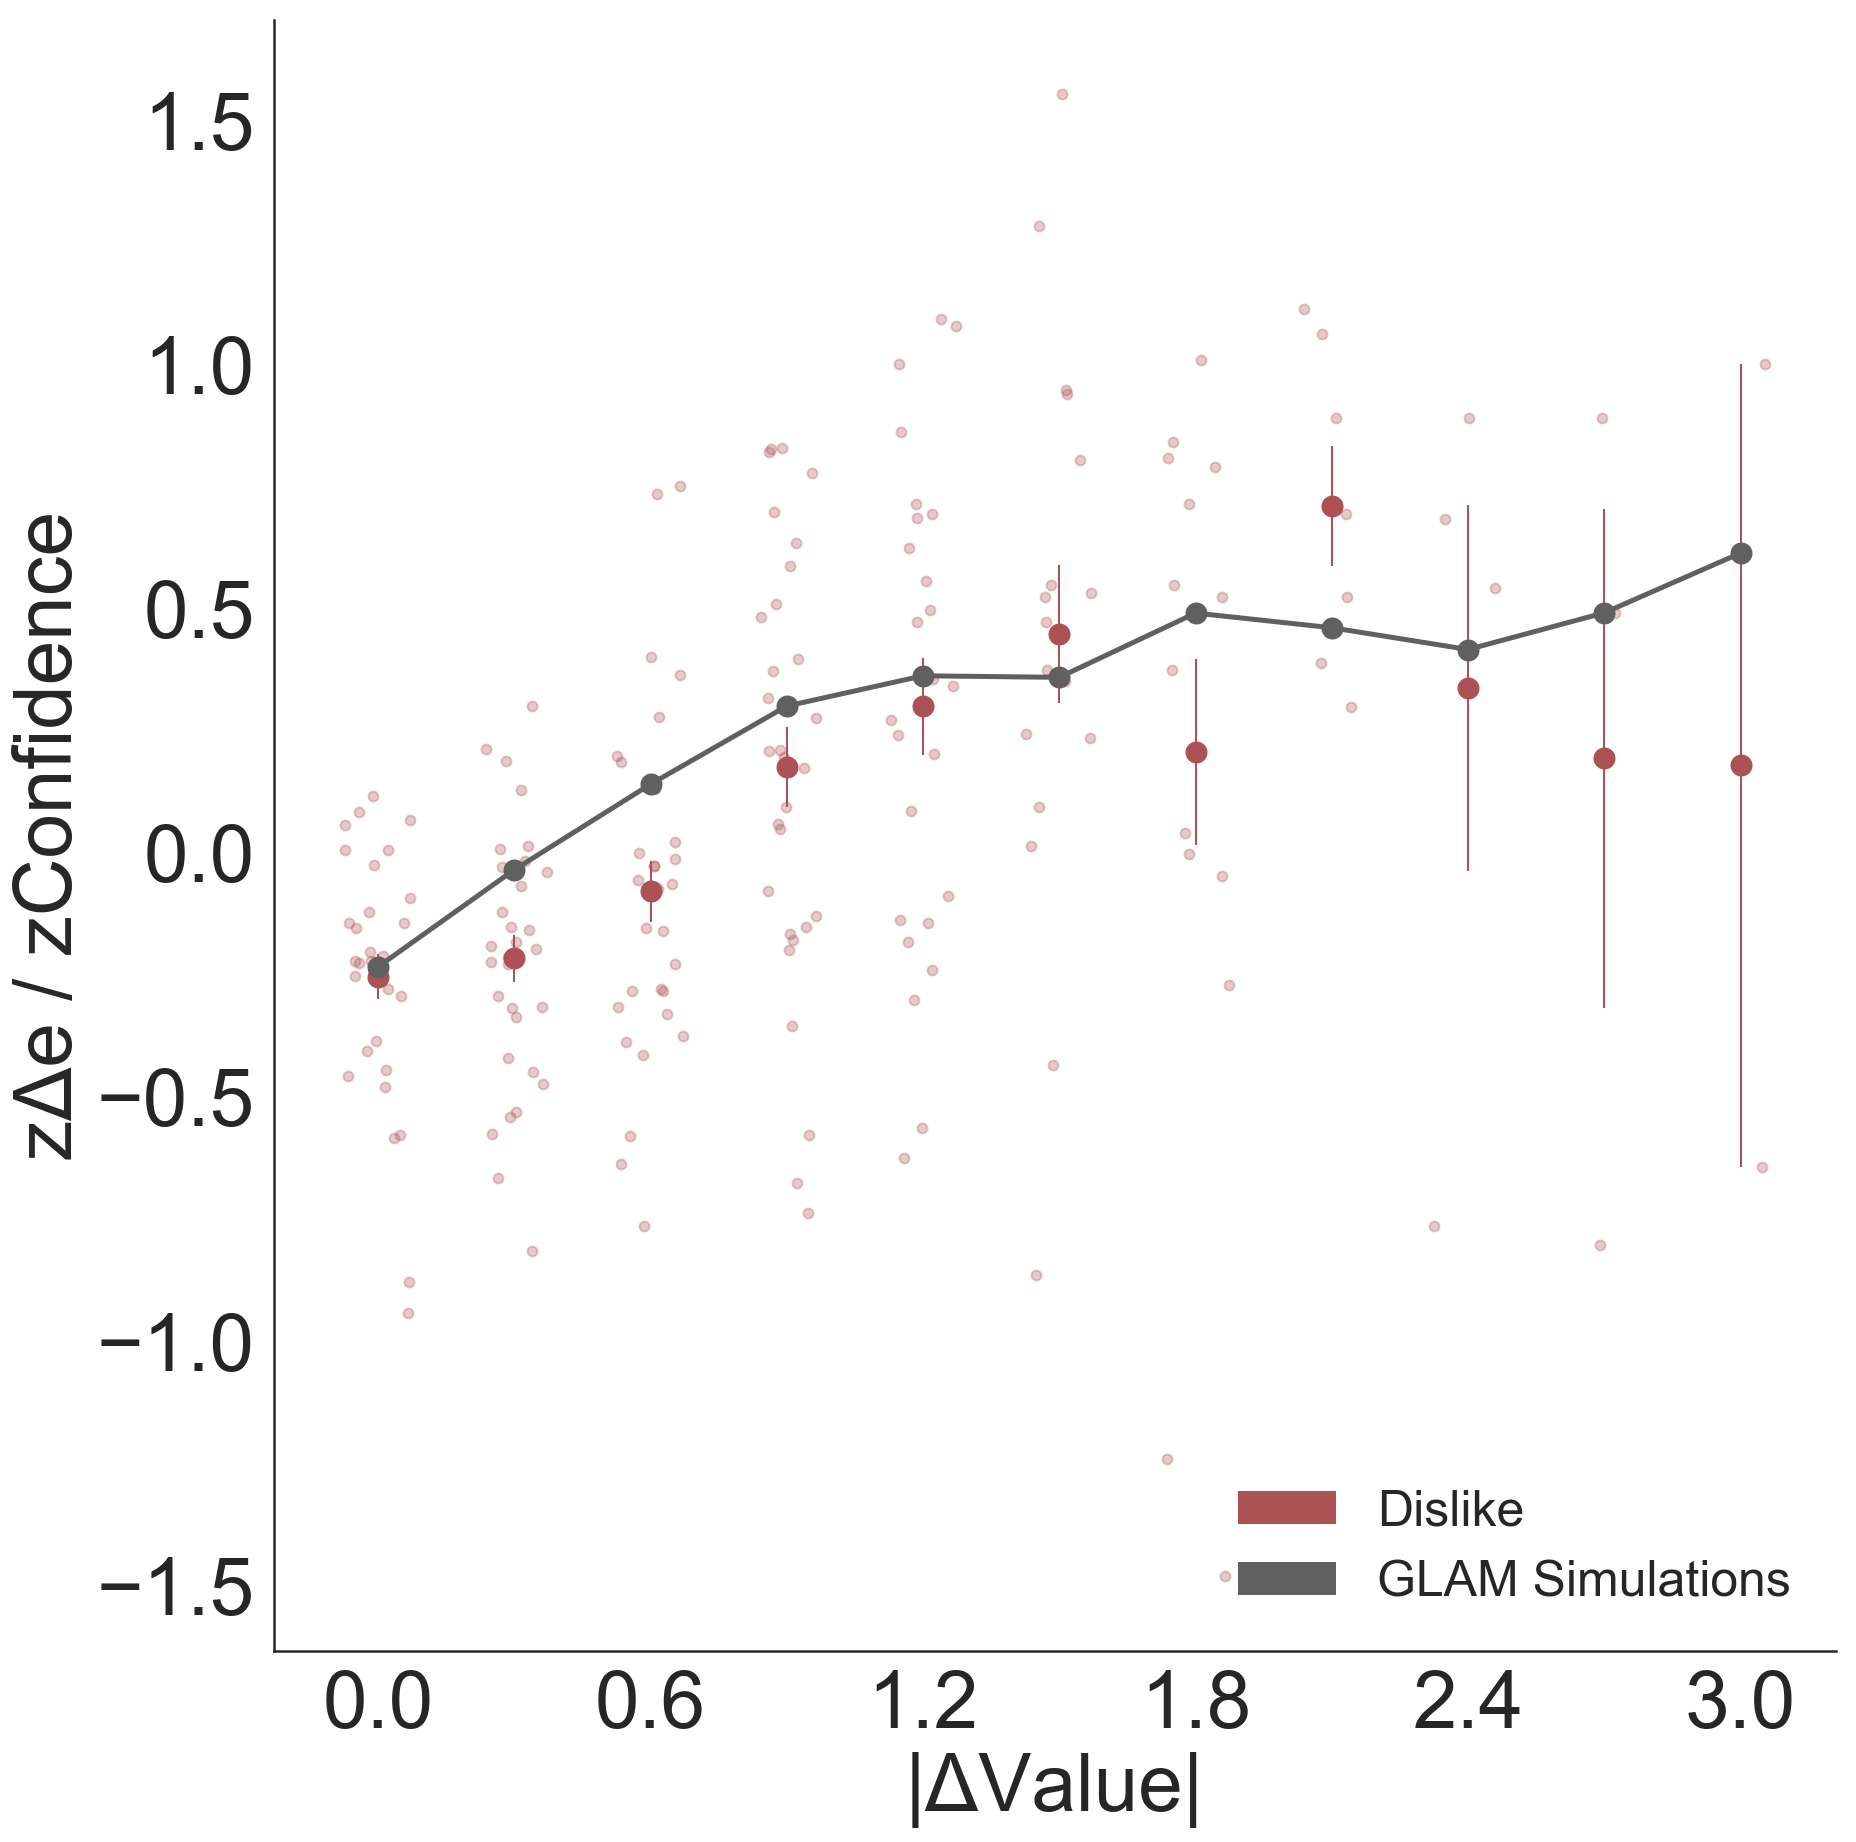

In [109]:
plot_DEv_Conf(data_simulation2, xlabel_skip=2,color1 = '#AC5255',label1 = 'Dislike')

Done with TotVal


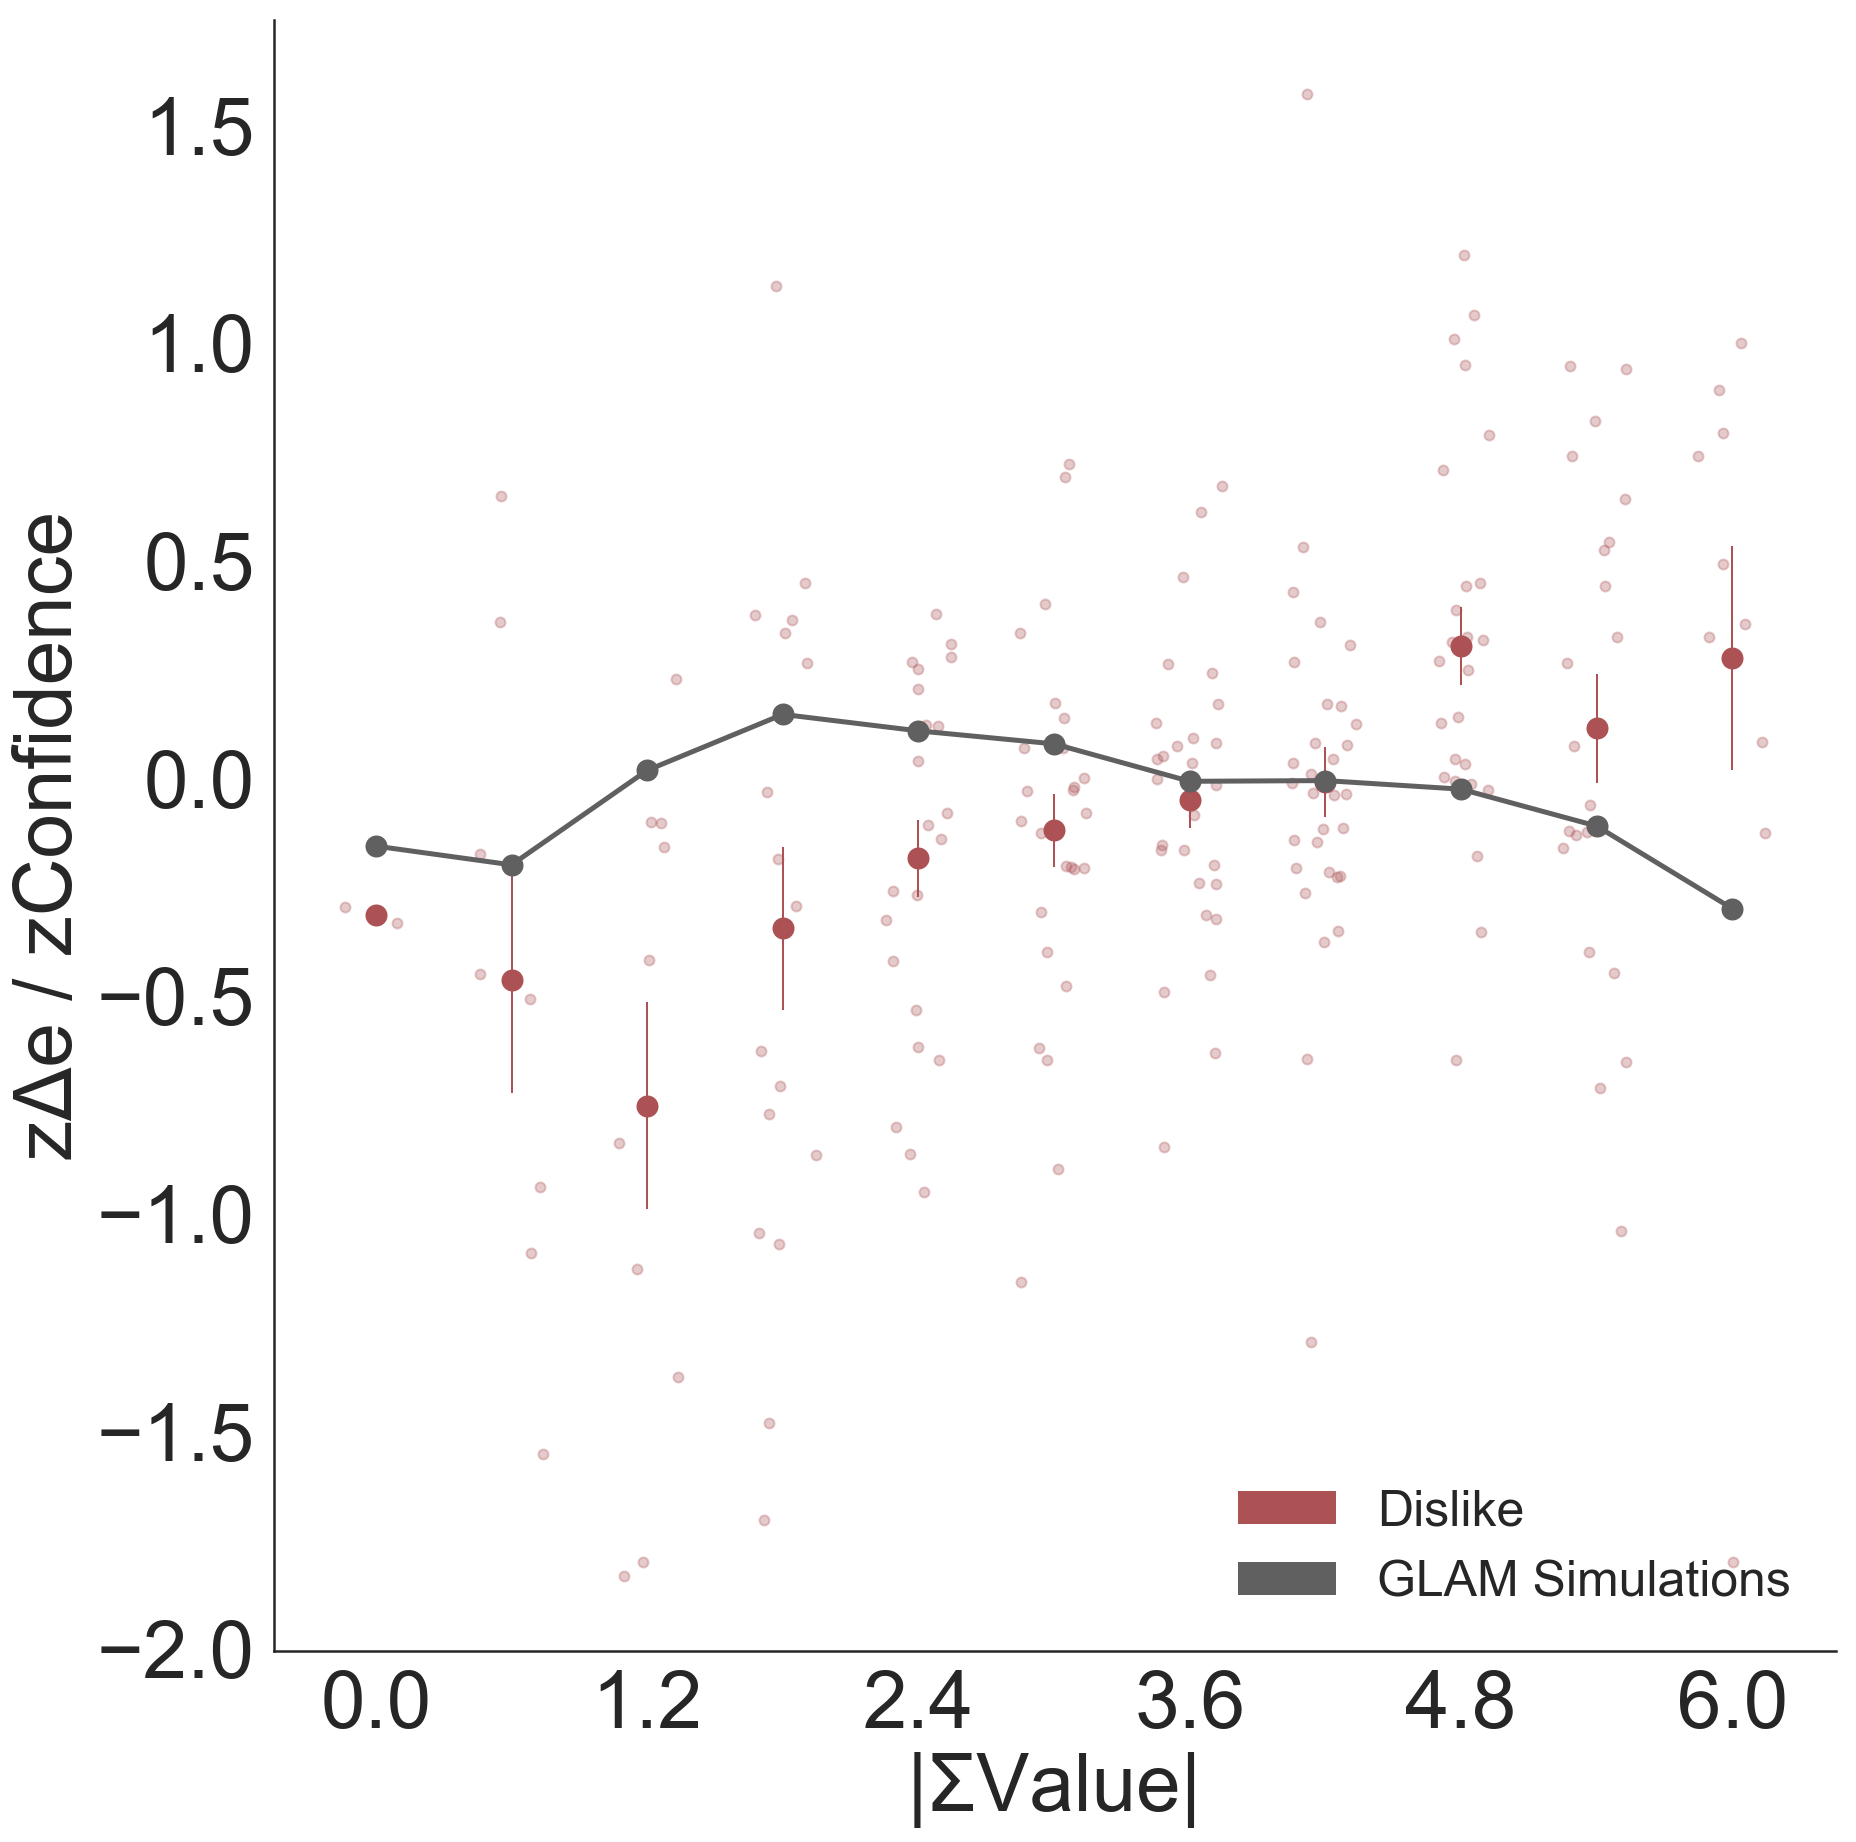

In [110]:
plot_DEv_Conf_TotVal(data_simulation2,'TotVal' , xlabel_skip=2,color1 = '#AC5255',label1 = 'Dislike')

Done with TotVal


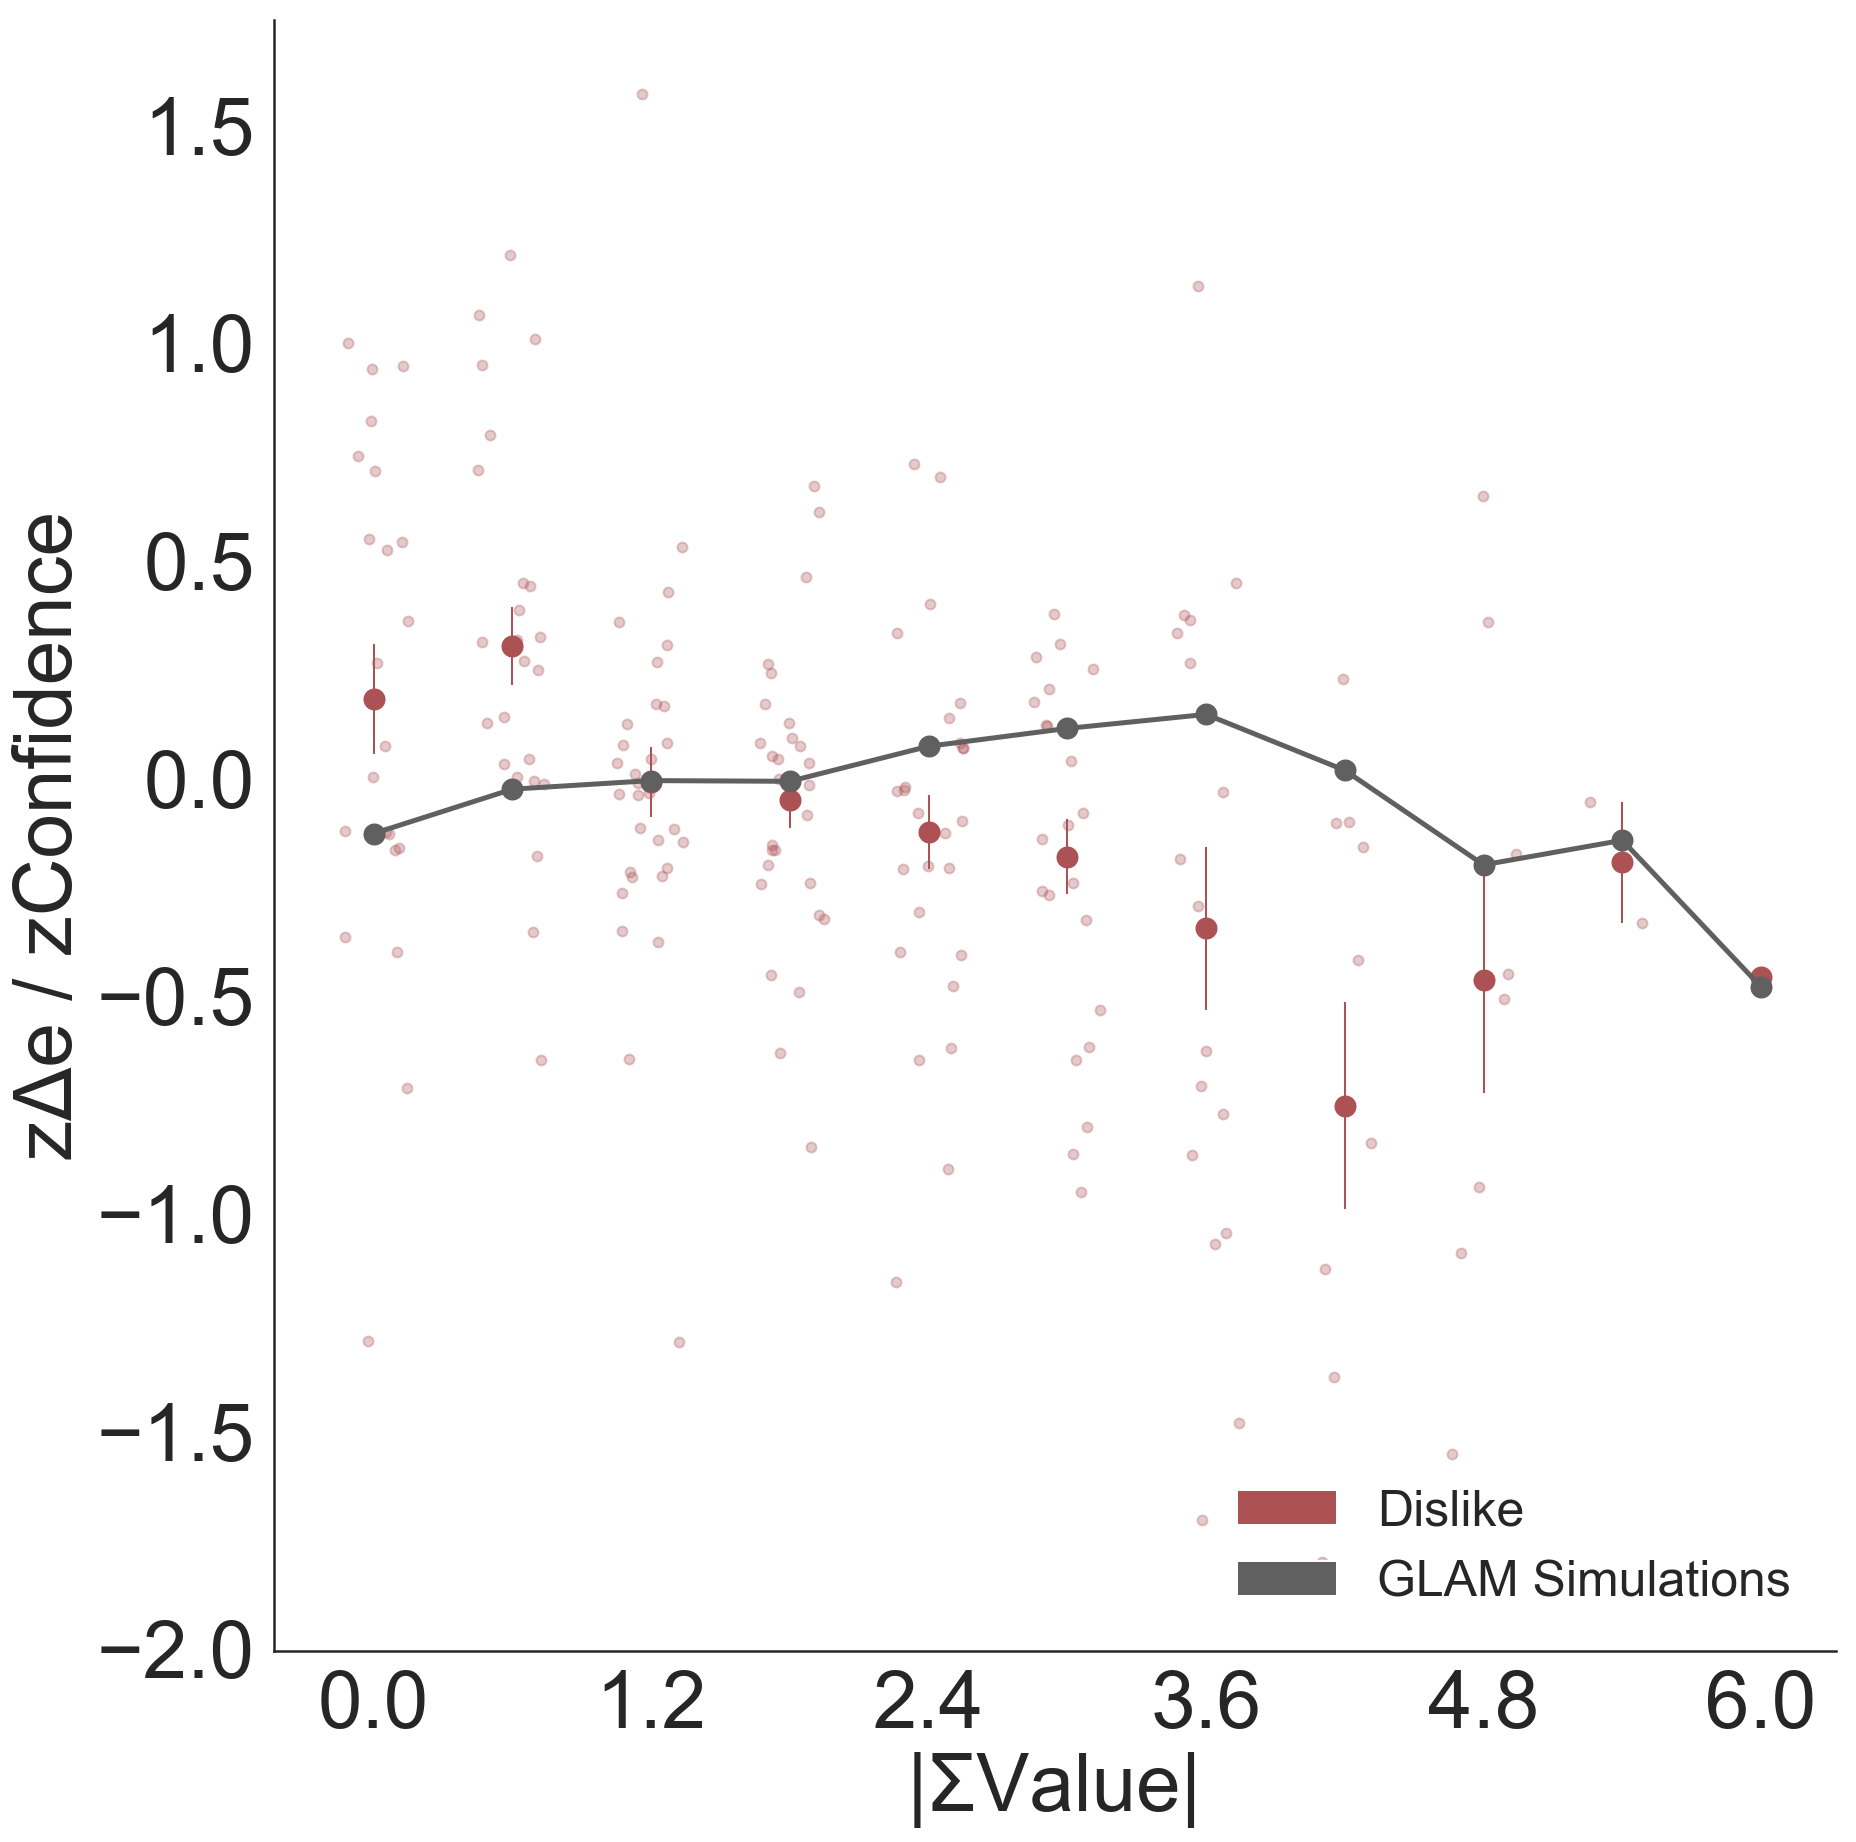

In [111]:
plot_DEv_Conf_TotVal(data_simulation2,'TotVal_orig' , xlabel_skip=2,color1 = '#AC5255',label1 = 'Dislike')